# Spatio-Temporal GNNs for Multi-Sensor Fusion in Fault Diagnosis

**BTP-I Project (22IM30036)**
**Supervisor: Prof. Jhareswar Maiti**

## 1. Introduction & Goal

This project aims to develop a robust model for early and accurate fault diagnosis in rotating machinery. [cite_start]Traditional methods often rely on single, unreliable sensors or require extensive manual feature engineering (like the SVM benchmark model [cite: 3]).

Our approach tests a different hypothesis: **Can we achieve high accuracy by learning features directly from raw signals and explicitly modeling the *physical* relationships between sensors?**

To do this, we use a Spatio-Temporal Graph Neural Network (ST-GNN) on the CWRU Bearing Dataset. We model the system as a graph where:
* **Nodes:** The two physical sensors (Drive-End and Fan-End).
* **Edge:** The physical connection via the motor housing.
* **Node Features:** The raw (or engineered) vibration signals from each sensor.
* 

## 2. Library Imports and Configuration

First, we install and import all necessary libraries and set up our global configuration. This includes:
* **PyTorch & PyG**: For building the GNN models.
* **Optuna**: For hyperparameter tuning.
* **skrebate**: For the ReliefF feature selection algorithm.
* **torchinfo**: For visualizing model architectures.
* **Scipy, Numpy, Pandas, Sklearn, Matplotlib**: For data handling, feature extraction, and evaluation.


In [1]:
# --- 1. Install Required Libraries ---
!pip install torch_geometric optuna torchinfo skrebate -q

# --- 2. Import All Libraries ---
import torch
import torch.nn.functional as F
from torch.nn import LSTM, Linear, BatchNorm1d, Dropout
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torchinfo import summary

import optuna
import numpy as np
import scipy.io
import scipy.stats
from scipy.stats import pearsonr
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from skrebate import ReliefF

# --- 3. Configuration ---
WINDOW_SIZE = 1024  # Size of each signal segment (1024 data points)
OVERLAP = 512       # 50% overlap between segments
DATA_DIR = '/kaggle/input/cwru-case-western-reserve-university-dataset/cwru'
BATCH_SIZE = 64
RANDOM_STATE = 42
N_FEATURES = 11 # 6 time-domain + 5 freq-domain

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

print(f"Libraries imported successfully.")
print(f"Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.9 MB/s eta 0:00:00a 0:00:01
Libraries imported successfully.
Using device: cuda


## 3. Data Loading & Preprocessing (Mixed-Load Strategy)

To build a robust model that generalizes to different operating conditions, we will not train on a single load. Instead, we use a **mixed-load training strategy**.

* **Training & Validation Set:** Data from 0 HP, 1 HP, and 2 HP loads.
* **Unseen Test Set:** Data from the 3 HP load.

This forces the model to learn load-invariant features. We first define the file mappings for all four operating conditions.

In [2]:
# --- 3.1. Define File Mappings for All Loads ---

# 0 HP Load
LABEL_MAPPING_0HP = {
    'Normal_0.mat': 0, 'B007_0.mat': 1, 'B014_0.mat': 1, 'B021_0.mat': 1,
    'IR007_0.mat': 2, 'IR014_0.mat': 2, 'IR021_0.mat': 2,
    'OR0076_0.mat': 3, 'OR0146_0.mat': 3, 'OR0216_0.mat': 3
}

# 1 HP Load
LABEL_MAPPING_1HP = {
    'Normal_1.mat': 0, 'B007_1.mat': 1, 'B014_1.mat': 1, 'B021_1.mat': 1,
    'IR007_1.mat': 2, 'IR014_1.mat': 2, 'IR021_1.mat': 2,
    'OR0076_1.mat': 3, 'OR0146_1.mat': 3, 'OR0216_1.mat': 3
}

# 2 HP Load
LABEL_MAPPING_2HP = {
    'Normal_2.mat': 0, 'B007_2.mat': 1, 'B014_2.mat': 1, 'B021_2.mat': 1,
    'IR007_2.mat': 2, 'IR014_2.mat': 2, 'IR021_2.mat': 2,
    'OR0076_2.mat': 3, 'OR0146_2.mat': 3, 'OR0216_2.mat': 3
}

# 3 HP Load (Unseen Test Set)
LABEL_MAPPING_3HP = {
    'Normal_3.mat': 0, 'B007_3.mat': 1, 'B014_3.mat': 1, 'B021_3.mat': 1,
    'IR007_3.mat': 2, 'IR014_3.mat': 2, 'IR021_3.mat': 2,
    'OR0076_3.mat': 3, 'OR0146_3.mat': 3, 'OR0216_3.mat': 3
}

# Combine all mappings for easier lookup
ALL_LABEL_MAPPINGS = {**LABEL_MAPPING_0HP, **LABEL_MAPPING_1HP, **LABEL_MAPPING_2HP, **LABEL_MAPPING_3HP}
CLASS_NAMES = ["Normal (0)", "Ball Fault (1)", "Inner Race (2)", "Outer Race (3)"]
num_classes = len(set(ALL_LABEL_MAPPINGS.values()))

print(f"Defined label mappings for all 4 loads (0, 1, 2, 3 HP).")
print(f"Total classes: {num_classes}")

Defined label mappings for all 4 loads (0, 1, 2, 3 HP).
Total classes: 4


### 3.2 Data Processing & Utility Functions

Here we define our core data processing pipeline. This includes:
1.  **`segment_signal`**: A function to chop the long raw signals into overlapping windows of 1024 points.
2.  **`get_raw_segments`**: A helper function to load and segment files *before* scaling. This is crucial for correctly fitting our `StandardScaler`.
3.  **File-based Splitting**: We split our *files* (from 0, 1, 2 HP loads) into training, validation, and a same-distribution test set. This prevents data leakage from overlapping segments.
4.  **Scaler Fitting**: We `fit` the `StandardScaler` *only* on the raw training segments. This scaler (`scaler_de_mixed`, `scaler_fe_mixed`) will be used for all models to ensure fair comparison.

In [3]:
# --- 3.2.1. Signal Processing Utility Functions ---

def segment_signal(signal, window_size, overlap):
    """Segments a 1D signal into overlapping windows."""
    segments = []
    step = window_size - overlap
    for i in range(0, len(signal) - window_size + 1, step):
        segments.append(signal[i:i + window_size])
    return np.array(segments)

def get_raw_segments(file_list, data_dir, label_mapping):
    """Loads and segments raw signals from a list of files without scaling."""
    all_de_segments = []
    all_fe_segments = []
    
    for file_name in file_list:
        file_path = os.path.join(data_dir, file_name)
        if not os.path.exists(file_path):
            print(f"Warning: File not found {file_path}, skipping.")
            continue
        mat_data = scipy.io.loadmat(file_path)
        
        de_key = [key for key in mat_data.keys() if 'DE_time' in key][0]
        fe_key = [key for key in mat_data.keys() if 'FE_time' in key][0]
        
        de_signal = mat_data[de_key].flatten()
        fe_signal = mat_data[fe_key].flatten()
        
        min_len = min(len(de_signal), len(fe_signal))
        de_signal = de_signal[:min_len]
        fe_signal = fe_signal[:min_len]
        
        all_de_segments.append(segment_signal(de_signal, WINDOW_SIZE, OVERLAP))
        all_fe_segments.append(segment_signal(fe_signal, WINDOW_SIZE, OVERLAP))
        
    if not all_de_segments:
        return np.array([]).reshape(0, WINDOW_SIZE), np.array([]).reshape(0, WINDOW_SIZE)
        
    return np.concatenate(all_de_segments, axis=0), np.concatenate(all_fe_segments, axis=0)

# --- 3.2.2. File-Based Train/Val/Test Split ---

print("Splitting mixed-load files (0, 1, 2 HP)...")
train_val_files_mixed = [f for f in {**LABEL_MAPPING_0HP, **LABEL_MAPPING_1HP, **LABEL_MAPPING_2HP}.keys() if os.path.exists(os.path.join(DATA_DIR, f))]
unseen_test_files_3hp = [f for f in LABEL_MAPPING_3HP.keys() if os.path.exists(os.path.join(DATA_DIR, f))]

train_val_labels_mixed = [ALL_LABEL_MAPPINGS[f] for f in train_val_files_mixed]

# Need at least 1 file per class for stratification (4 classes)
test_split_size = max(4, int(len(train_val_files_mixed) * 0.1)) # 10% or 4, whichever is larger
val_split_size = max(4, int(len(train_val_files_mixed) * 0.1)) # 10% or 4

# Split off same-distribution test set
train_files_mixed, test_files_mixed_samedist = train_test_split(
    train_val_files_mixed, 
    test_size=test_split_size, 
    random_state=RANDOM_STATE, 
    stratify=train_val_labels_mixed
)

train_labels_mixed = [ALL_LABEL_MAPPINGS[f] for f in train_files_mixed]

# Split remaining into train and validation
train_files_mixed, val_files_mixed = train_test_split(
    train_files_mixed, 
    test_size=val_split_size, 
    random_state=RANDOM_STATE, 
    stratify=train_labels_mixed
)

print(f"Total 0,1,2HP files: {len(train_val_files_mixed)}")
print(f"Training files: {len(train_files_mixed)}")
print(f"Validation files: {len(val_files_mixed)}")
print(f"Same-Dist Test files: {len(test_files_mixed_samedist)}")
print(f"Unseen (3HP) Test files: {len(unseen_test_files_3hp)}")

# --- 3.2.3. Fit Scalers ---

print("\nFitting scalers on mixed training data (0, 1, 2 HP)...")
train_de_segs_mixed_raw, train_fe_segs_mixed_raw = get_raw_segments(train_files_mixed, DATA_DIR, ALL_LABEL_MAPPINGS)

scaler_de_mixed = StandardScaler().fit(train_de_segs_mixed_raw)
scaler_fe_mixed = StandardScaler().fit(train_fe_segs_mixed_raw)
print("Mixed-load scalers fitted.")

Splitting mixed-load files (0, 1, 2 HP)...
Total 0,1,2HP files: 30
Training files: 22
Validation files: 4
Same-Dist Test files: 4
Unseen (3HP) Test files: 10

Fitting scalers on mixed training data (0, 1, 2 HP)...
Mixed-load scalers fitted.


## 4. Feature Engineering

As identified in the research paper and confirmed by our initial models, using raw time-series signals directly can be challenging for the model, especially in distinguishing complex faults under varying loads.

To improve performance, we will create a richer feature set, similar to the approach in the paper. We will extract statistical features from the time domain and energy features from the frequency domain.

* **Time-Domain Features:** Mean, RMS, Skewness, Kurtosis, Peak-to-Peak (P2P), and Crest Factor.
* **Frequency-Domain Features:** Mean energy in 5 distinct frequency bands, derived from the Fast Fourier Transform (FFT).

In [4]:
# --- 4.1. Feature Extraction Functions ---

import scipy.stats

def extract_time_features(segment):
    """Extracts a set of statistical time-domain features from a signal segment."""
    mean = np.mean(segment)
    rms = np.sqrt(np.mean(segment**2))
    skewness = scipy.stats.skew(segment)
    kurt = scipy.stats.kurtosis(segment)
    p2p = np.ptp(segment) # Peak-to-peak
    
    # Crest Factor: Peak / RMS
    crest_factor = (np.max(np.abs(segment)) / rms) if rms > 1e-6 else 0
    
    return [mean, rms, skewness, kurt, p2p, crest_factor]

def extract_freq_features(segment, n_bands=5):
    """Extracts frequency-domain features (energy in bands) from a signal segment."""
    N = len(segment)
    
    # Calculate FFT
    fft_vals = np.fft.fft(segment)
    fft_mag = np.abs(fft_vals)[:N // 2] * 2 / N # Get magnitude of positive frequencies
    
    # Split the spectrum into n_bands
    band_energies = []
    band_size = len(fft_mag) // n_bands
    
    for i in range(n_bands):
        start = i * band_size
        end = (i + 1) * band_size if i < n_bands - 1 else len(fft_mag)
        
        # Calculate mean energy in the band
        band_energy = np.mean(fft_mag[start:end])
        band_energies.append(band_energy)
        
    return band_energies

def extract_all_features(segment):
    """Combines time and frequency features for a single segment."""
    time_feats = extract_time_features(segment)
    freq_feats = extract_freq_features(segment, n_bands=5) # 5 frequency bands
    
    # Concatenate all features
    return np.concatenate([time_feats, freq_feats])

# Test the feature extractor
test_segment = np.random.rand(WINDOW_SIZE)
features = extract_all_features(test_segment)

# N_FEATURES was defined as 11 in the config cell. This confirms it.
assert len(features) == N_FEATURES, f"Feature length mismatch: {len(features)} != {N_FEATURES}"

print(f"Feature extraction functions defined.")
print(f"Total features per segment: {N_FEATURES} (6 time, 5 frequency)")

Feature extraction functions defined.
Total features per segment: 11 (6 time, 5 frequency)


Generating Data Exploration and Feature Engineering Visualizations...
Raw signal plot saved as 'raw_signal_window_plot.png'.

--- Feature Extraction Example (first 5 segments) ---


,Mean,RMS,Skewness,Kurtosis,P2P,CrestFactor,FFT_Band1,FFT_Band2,FFT_Band3,FFT_Band4,FFT_Band5
0,-0.019691,1.283501,-0.318030,15.160762,17.556013,6.995683,0.031251,0.025741,0.132309,0.030386,0.006413
1,-0.014755,1.311615,0.179305,12.662182,17.478103,6.773414,0.028717,0.026979,0.137282,0.032039,0.006015
2,-0.017203,1.436025,-0.130843,9.099644,17.286507,6.165006,0.032371,0.027308,0.147744,0.032881,0.006032
3,-0.022429,1.416402,-0.317094,9.239804,15.249620,5.695968,0.040871,0.027803,0.147549,0.033053,0.008627
4,-0.018809,1.285501,-0.117835,11.090155,14.846944,5.849218,0.031679,0.026401,0.137074,0.028769,0.005847


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  


Feature distribution plots saved as 'feature_distribution_plots.png'.


<Figure size 1500x400 with 0 Axes>

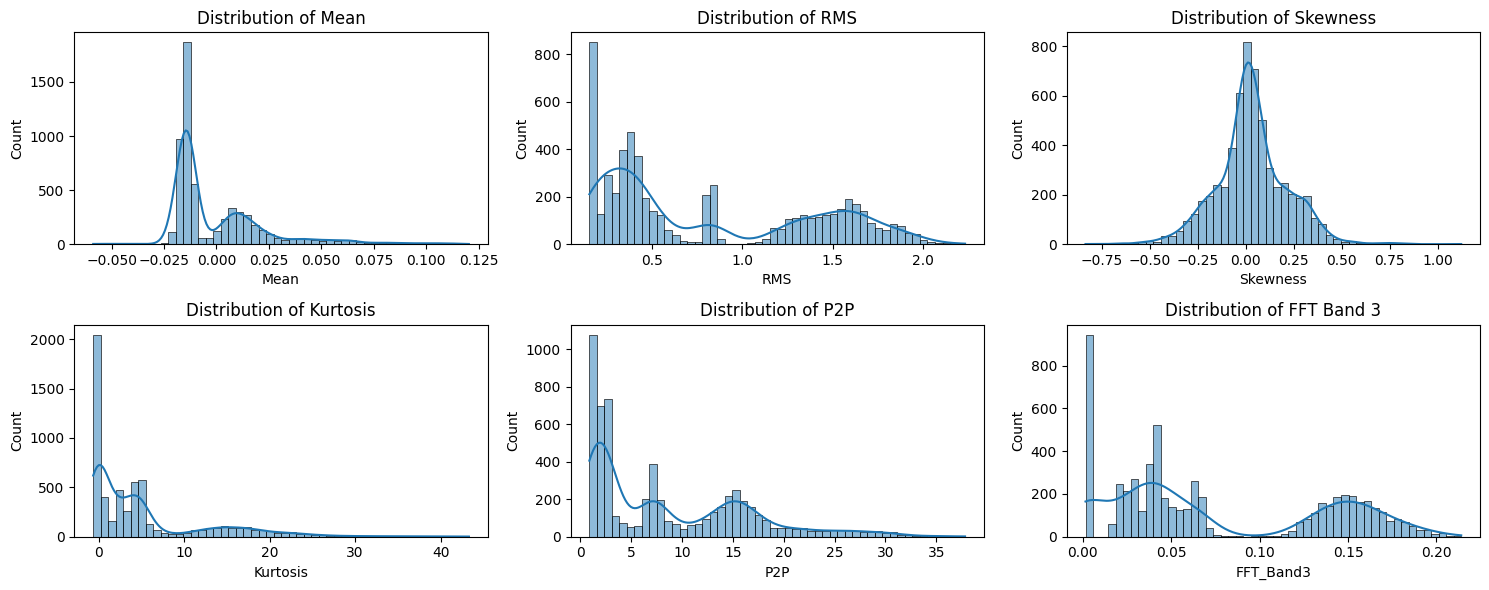

In [5]:
# --- 4.2. Data Exploration & Feature Engineering Visualization ---

print("Generating Data Exploration and Feature Engineering Visualizations...")

# --- 1. Load a sample raw signal for plotting ---
# We'll use the first file from our mixed training set
sample_file_name = train_files_mixed[0]
sample_file_path = os.path.join(DATA_DIR, sample_file_name)

mat_data = scipy.io.loadmat(sample_file_path)
de_key = [key for key in mat_data.keys() if 'DE_time' in key][0]
sample_signal_raw = mat_data[de_key].flatten()

# --- 2. Create the raw signal plot (like Fig 7 top) ---
plt.figure(figsize=(15, 4))
plt.plot(sample_signal_raw, lw=0.5)
plt.title(f"Raw DE Signal from '{sample_file_name}' (Full Signal View)")
plt.xlabel("Data Points")
plt.ylabel("Amplitude")

# Highlight a 1024-point window
plt.axvspan(10000, 10000 + WINDOW_SIZE, color='red', alpha=0.3, label=f'{WINDOW_SIZE}-point Window')
plt.legend()
plt.xlim(0, 50000) # Show a subset for clarity
plt.savefig("raw_signal_window_plot.png")
plt.clf() # Clear plot

print("Raw signal plot saved as 'raw_signal_window_plot.png'.")

# --- 3. Generate feature table (like Fig 7 bottom) ---
# We'll use the pre-fitted scalers (scaler_de_mixed)

# Segment the raw signal
sample_segments_raw = segment_signal(sample_signal_raw, WINDOW_SIZE, OVERLAP)

# Scale the segments
sample_segments_scaled = scaler_de_mixed.transform(sample_segments_raw)

# Extract features for the first few segments
feature_list = []
feature_names = [
    'Mean', 'RMS', 'Skewness', 'Kurtosis', 'P2P', 'CrestFactor',
    'FFT_Band1', 'FFT_Band2', 'FFT_Band3', 'FFT_Band4', 'FFT_Band5'
]

for i in range(min(5, len(sample_segments_scaled))): # Get features for first 5 segments
    segment = sample_segments_scaled[i]
    features = extract_all_features(segment)
    feature_list.append(features)

# Create DataFrame
features_df = pd.DataFrame(feature_list, columns=feature_names)

print("\n--- Feature Extraction Example (first 5 segments) ---")
# Display the DataFrame in a nice format (will render well in the notebook)
display(features_df)

# --- 4. Plot feature distributions (Bonus: similar to Fig 6 in paper) ---
# We'll use the full training set segments for a better distribution
# 'train_de_segs_mixed_raw' is already in memory from fitting the scaler
train_segments_scaled_de = scaler_de_mixed.transform(train_de_segs_mixed_raw)

all_features_list_de = []
for segment in train_segments_scaled_de:
    all_features_list_de.append(extract_all_features(segment))

all_features_df_de = pd.DataFrame(all_features_list_de, columns=feature_names)

# Plot distributions for a few key features
plt.figure(figsize=(15, 6))
plt.subplot(2, 3, 1)
sns.histplot(all_features_df_de['Mean'], kde=True, bins=50)
plt.title('Distribution of Mean')

plt.subplot(2, 3, 2)
sns.histplot(all_features_df_de['RMS'], kde=True, bins=50)
plt.title('Distribution of RMS')

plt.subplot(2, 3, 3)
sns.histplot(all_features_df_de['Skewness'], kde=True, bins=50)
plt.title('Distribution of Skewness')

plt.subplot(2, 3, 4)
sns.histplot(all_features_df_de['Kurtosis'], kde=True, bins=50)
plt.title('Distribution of Kurtosis')

plt.subplot(2, 3, 5)
sns.histplot(all_features_df_de['P2P'], kde=True, bins=50)
plt.title('Distribution of P2P')

plt.subplot(2, 3, 6)
sns.histplot(all_features_df_de['FFT_Band3'], kde=True, bins=50)
plt.title('Distribution of FFT Band 3')

plt.tight_layout()
plt.savefig("feature_distribution_plots.png")
print("\nFeature distribution plots saved as 'feature_distribution_plots.png'.")

Generating raw signal plots by fault type (DE and FE side-by-side)...


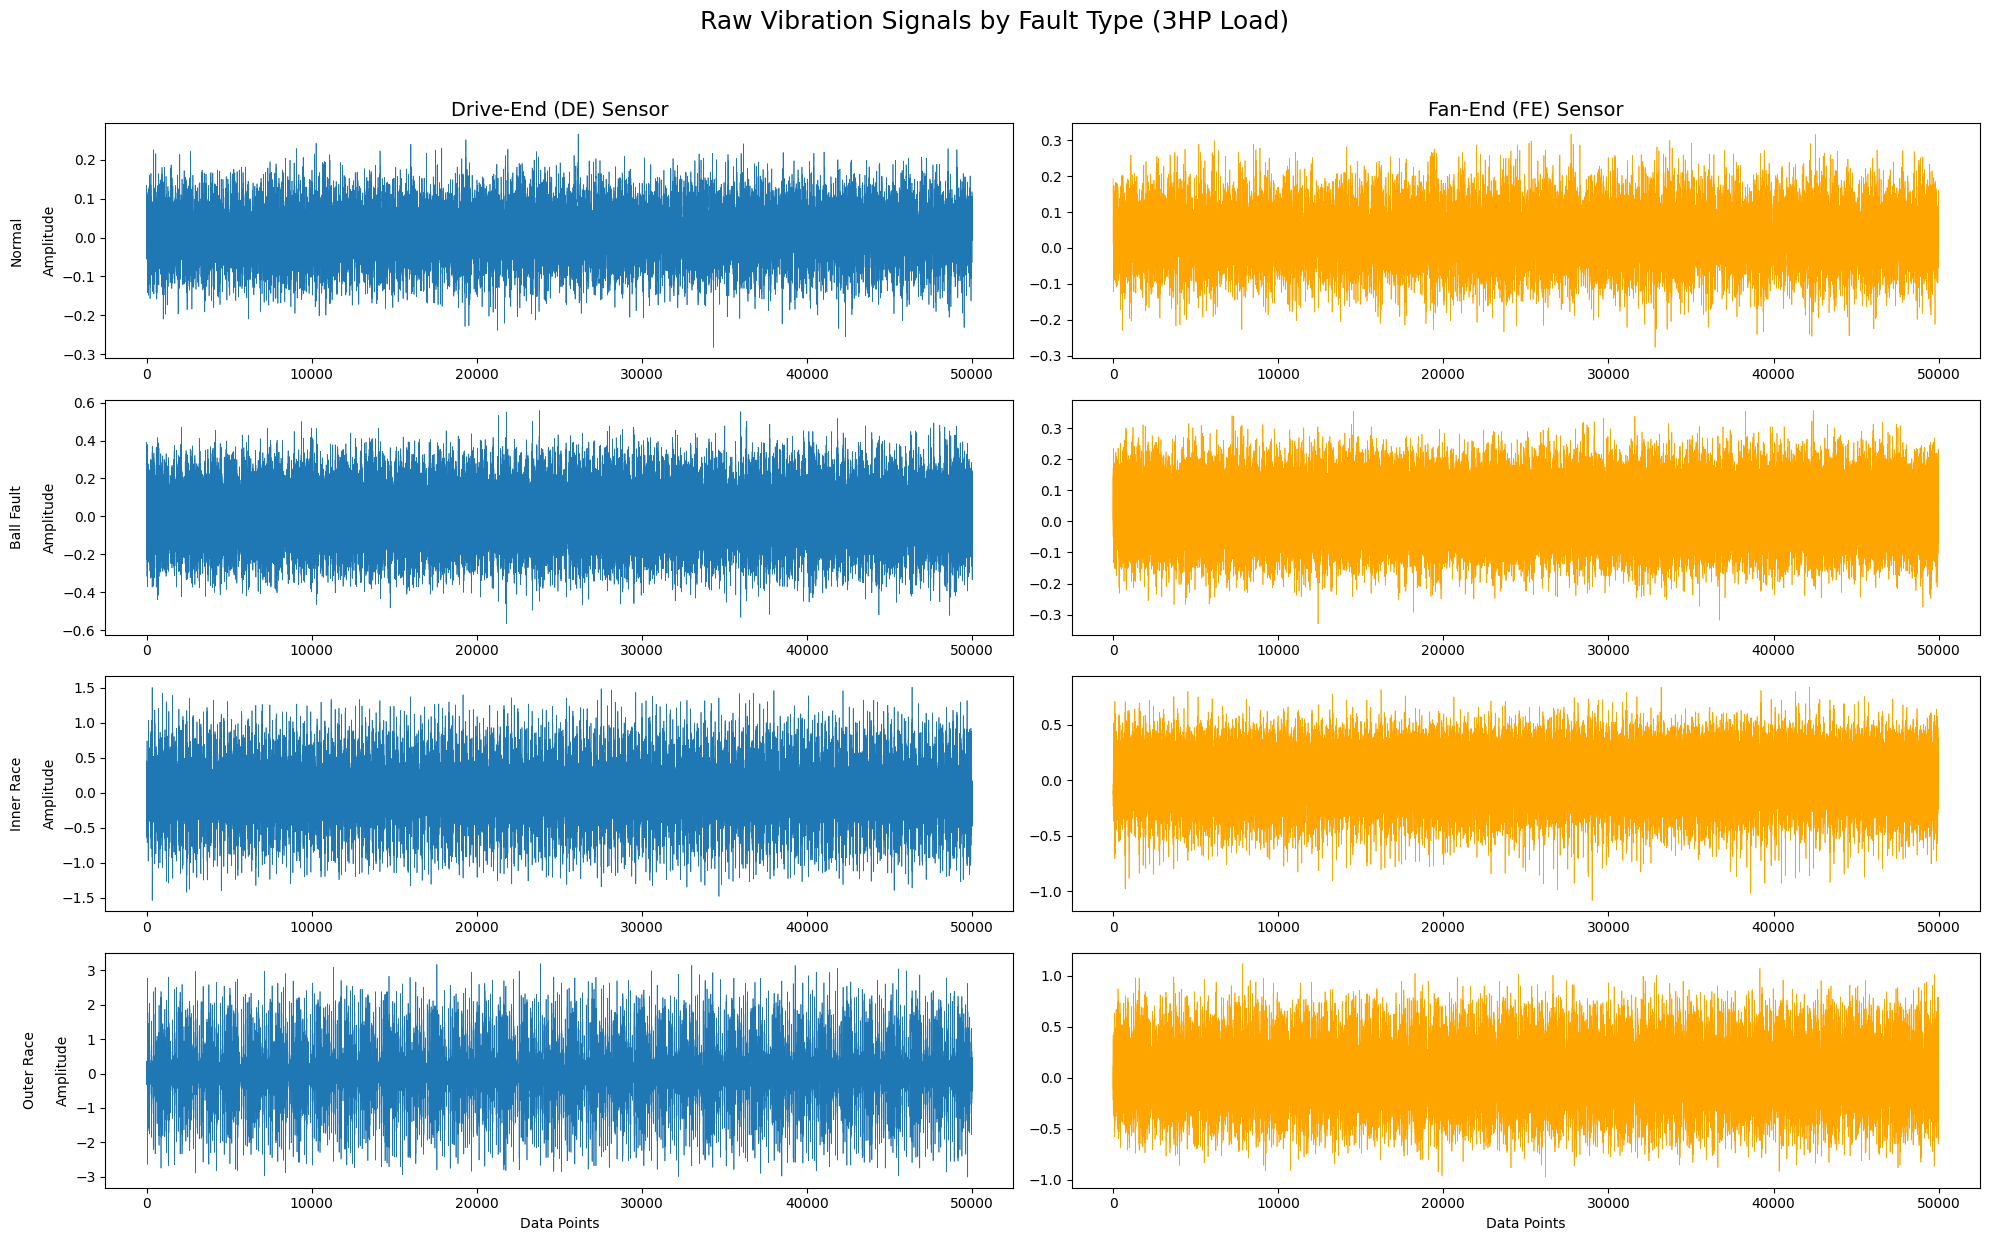

Raw signal plots by fault type (DE & FE) saved as 'raw_signals_by_fault_type_DE_FE.png'


In [25]:
# --- 4.3. Data Exploration: Plotting Signals by Fault Type (DE and FE) ---

print("Generating raw signal plots by fault type (DE and FE side-by-side)...")

# We will use one sample file from the 3HP (unseen) dataset for each fault type
sample_files = {
    "Normal": "Normal_3.mat",
    "Ball Fault": "B007_3.mat",
    "Inner Race": "IR007_3.mat",
    "Outer Race": "OR0076_3.mat"
}

# --- Create a 4x2 subplot grid ---
fig, axes = plt.subplots(4, 2, figsize=(20, 12))
fig.suptitle("Raw Vibration Signals by Fault Type (3HP Load)", fontsize=18, y=1.03)

# Set column titles
axes[0, 0].set_title("Drive-End (DE) Sensor", fontsize=14)
axes[0, 1].set_title("Fan-End (FE) Sensor", fontsize=14)

for i, (fault_name, file_name) in enumerate(sample_files.items()):
    file_path = os.path.join(DATA_DIR, file_name)
    
    if os.path.exists(file_path):
        mat_data = scipy.io.loadmat(file_path)
        
        # Get keys for both DE and FE sensors
        de_key = [key for key in mat_data.keys() if 'DE_time' in key][0]
        fe_key = [key for key in mat_data.keys() if 'FE_time' in key][0]
        
        de_signal = mat_data[de_key].flatten()
        fe_signal = mat_data[fe_key].flatten()
        
        # Plot DE signal (left column)
        axes[i, 0].plot(de_signal[:50000], lw=0.5)
        axes[i, 0].set_ylabel(f"{fault_name}\n\nAmplitude")
        
        # Plot FE signal (right column)
        axes[i, 1].plot(fe_signal[:50000], lw=0.5, color='orange')
        
    else:
        # Handle missing files
        axes[i, 0].set_title(f"DE: {file_name} not found", color='red')
        axes[i, 0].set_ylabel(f"{fault_name}\n\nAmplitude")
        axes[i, 1].set_title(f"FE: {file_name} not found", color='red')

# Set x-axis labels only on the bottom row
axes[3, 0].set_xlabel("Data Points")
axes[3, 1].set_xlabel("Data Points")

plt.tight_layout()
plt.savefig("raw_signals_by_fault_type_DE_FE.png")
plt.show()

print("Raw signal plots by fault type (DE & FE) saved as 'raw_signals_by_fault_type_DE_FE.png'")

Generating improved sliding window visualization...


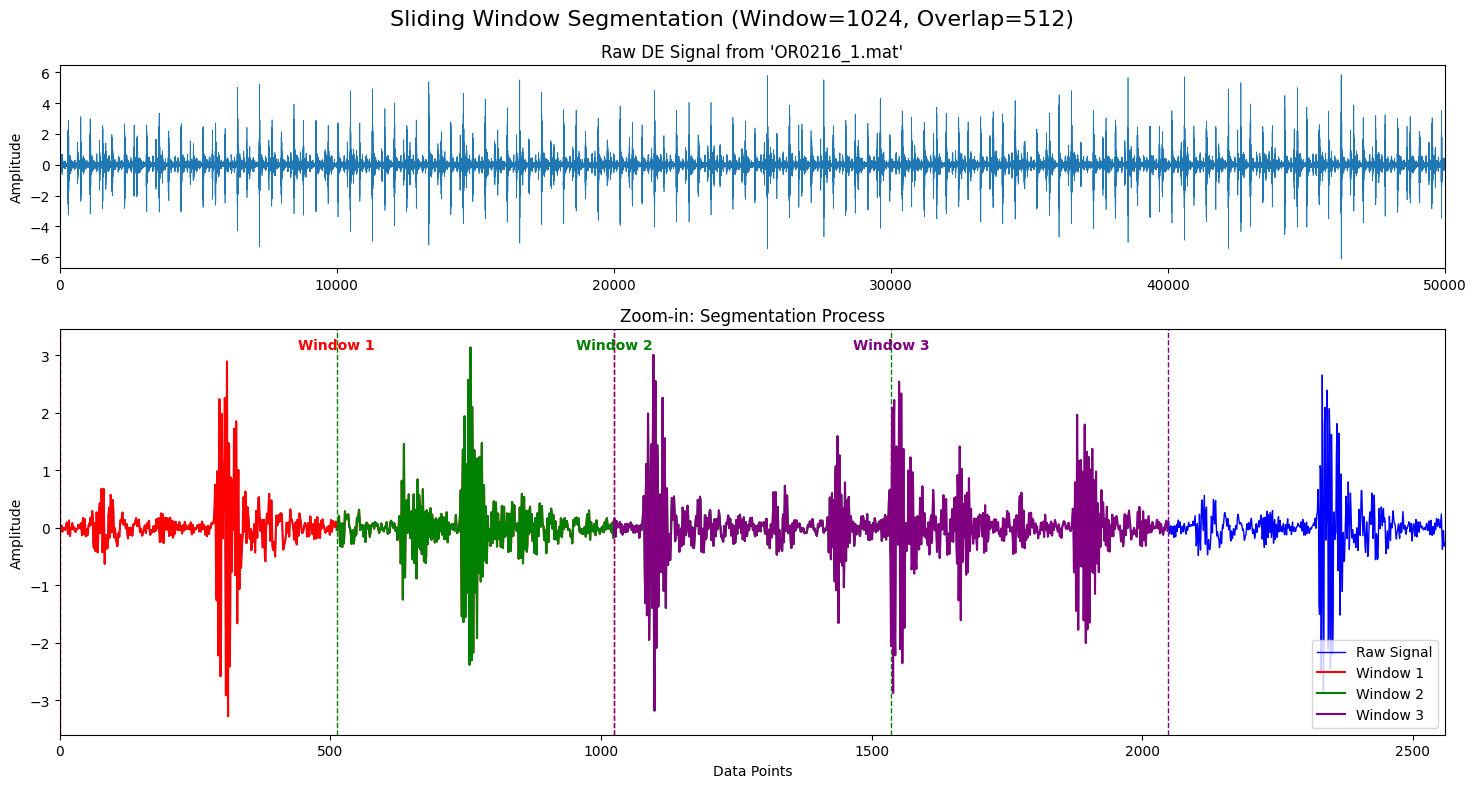

Improved sliding window visualization saved as 'sliding_window_visualization_improved.png'


In [27]:
# --- 4.4. Data Exploration: Visualizing the Sliding Window Segmentation (Improved) ---

print("Generating improved sliding window visualization...")

# --- 1. Load a sample raw signal ---
# We'll use the first file from our mixed training set
sample_file_name = train_files_mixed[0]
sample_file_path = os.path.join(DATA_DIR, sample_file_name)

mat_data = scipy.io.loadmat(sample_file_path)
de_key = [key for key in mat_data.keys() if 'DE_time' in key][0]
sample_signal_raw = mat_data[de_key].flatten()

# --- 2. Create a 2-row subplot ---
fig, axes = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [1, 2]})
fig.suptitle(f"Sliding Window Segmentation (Window={WINDOW_SIZE}, Overlap={OVERLAP})", fontsize=16)

# --- 3. Plot 1: The Full Signal (subset) ---
axes[0].plot(sample_signal_raw[:50000], lw=0.5)
axes[0].set_title(f"Raw DE Signal from '{sample_file_name}'")
axes[0].set_ylabel("Amplitude")
axes[0].set_xlim(0, 50000)

# --- 4. Plot 2: Zoom-in on Segmentation ---
step = WINDOW_SIZE - OVERLAP
zoom_length = (step * 3) + WINDOW_SIZE # Show first 3 full windows
signal_portion = sample_signal_raw[:zoom_length]

axes[1].plot(signal_portion, lw=1, label="Raw Signal", color='blue')
axes[1].set_title("Zoom-in: Segmentation Process")
axes[1].set_xlabel("Data Points")
axes[1].set_ylabel("Amplitude")

# Draw the overlapping windows
colors = ['red', 'green', 'purple']
for i in range(3): # Draw first 3 windows
    start = i * step
    end = start + WINDOW_SIZE
    
    # Plot each window segment with a different color
    axes[1].plot(range(start, end), sample_signal_raw[start:end], lw=1.5, color=colors[i], label=f"Window {i+1}")
    
    # Add vertical lines to show boundaries
    axes[1].axvline(x=start, color=colors[i], linestyle='--', lw=1)
    axes[1].axvline(x=end, color=colors[i], linestyle='--', lw=1)
    
    # Add text label
    axes[1].text(start + WINDOW_SIZE / 2, plt.gca().get_ylim()[1] * 0.9, f"Window {i+1}", 
                 horizontalalignment='center', color=colors[i], weight='bold')

axes[1].legend(loc='lower right')
axes[1].set_xlim(0, zoom_length)

plt.tight_layout()
plt.savefig("sliding_window_visualization_improved.png")
plt.show()

print("Improved sliding window visualization saved as 'sliding_window_visualization_improved.png'")

### 3.3. Graph Dataset Creation Functions

Now that we have our fitted scalers and feature-extraction logic, we need functions to convert our lists of files into PyTorch Geometric `Data` objects. We will create three different functions, one for each model type we plan to build:

1.  **`create_graph_list_raw`**: For models using **raw signals** (1D-CNN, ST-GNN v1). It will take the scaled 1024-point segments as node features.
2.  **`create_graph_list_features`**: For models using **handcrafted features** (ST-GNN v2). It will extract the 11 features from the scaled segments and use that vector as node features.
3.  **`create_graph_list_features_weighted`**: For models using **features and weighted edges** (ST-GNN v3). It does the same as the function above but also calculates and adds a `edge_weight` based on the correlation between the raw DE and FE signals.

We will also define our reusable `train` and `evaluate` functions here.

In [6]:
# --- 3.3. Graph Dataset Creation Functions ---

edge_index_global = torch.tensor([[0, 1], [1, 0]], dtype=torch.long)

def create_graph_list_raw(file_list, data_dir, label_mapping, scaler_de, scaler_fe):
    """Creates a list of PyG Data objects for RAW signal models."""
    graph_data_list = []
    for file_name in file_list:
        file_path = os.path.join(data_dir, file_name)
        if not os.path.exists(file_path): continue
        label = label_mapping[file_name]
        mat_data = scipy.io.loadmat(file_path)
        
        de_key = [key for key in mat_data.keys() if 'DE_time' in key][0]
        fe_key = [key for key in mat_data.keys() if 'FE_time' in key][0]
        
        de_signal = mat_data[de_key].flatten()
        fe_signal = mat_data[fe_key].flatten()
        
        min_len = min(len(de_signal), len(fe_signal))
        de_signal, fe_signal = de_signal[:min_len], fe_signal[:min_len]

        de_segments_raw = segment_signal(de_signal, WINDOW_SIZE, OVERLAP)
        fe_segments_raw = segment_signal(fe_signal, WINDOW_SIZE, OVERLAP)
        
        if de_segments_raw.size > 0:
            de_segments_norm = scaler_de.transform(de_segments_raw)
            fe_segments_norm = scaler_fe.transform(fe_segments_raw)
        
            for i in range(len(de_segments_norm)):
                x = torch.tensor([de_segments_norm[i], fe_segments_norm[i]], dtype=torch.float)
                y = torch.tensor([label], dtype=torch.long)
                graph_data = Data(x=x, edge_index=edge_index_global, y=y)
                graph_data_list.append(graph_data)
                
    print(f"Loaded {len(graph_data_list)} raw signal samples from {len(file_list)} files.")
    return graph_data_list

def create_graph_list_features(file_list, data_dir, label_mapping, scaler_de, scaler_fe):
    """Creates a list of PyG Data objects for FEATURE-BASED models."""
    all_data_list = []
    for file_name in file_list:
        file_path = os.path.join(data_dir, file_name)
        if not os.path.exists(file_path): continue
        label = label_mapping[file_name]
        
        mat_data = scipy.io.loadmat(file_path)
        de_key = [key for key in mat_data.keys() if 'DE_time' in key][0]
        fe_key = [key for key in mat_data.keys() if 'FE_time' in key][0]
        
        de_signal = mat_data[de_key].flatten()
        fe_signal = mat_data[fe_key].flatten()
        min_len = min(len(de_signal), len(fe_signal))
        de_signal, fe_signal = de_signal[:min_len], fe_signal[:min_len]

        de_segments_raw = segment_signal(de_signal, WINDOW_SIZE, OVERLAP)
        fe_segments_raw = segment_signal(fe_signal, WINDOW_SIZE, OVERLAP)
        
        if de_segments_raw.size > 0:
            de_segments_norm = scaler_de.transform(de_segments_raw)
            fe_segments_norm = scaler_fe.transform(fe_segments_raw)

            for i in range(len(de_segments_norm)):
                de_feats = extract_all_features(de_segments_norm[i])
                fe_feats = extract_all_features(fe_segments_norm[i])
                
                x = torch.tensor([de_feats, fe_feats], dtype=torch.float)
                y = torch.tensor([label], dtype=torch.long)
                graph_data = Data(x=x, edge_index=edge_index_global, y=y)
                all_data_list.append(graph_data)
                
    print(f"Loaded {len(all_data_list)} feature-based samples from {len(file_list)} files.")
    return all_data_list

def create_graph_list_features_weighted(file_list, data_dir, label_mapping, scaler_de, scaler_fe):
    """Creates a list of PyG Data objects for FEATURE-BASED + WEIGHTED models."""
    all_data_list = []
    for file_name in file_list:
        file_path = os.path.join(data_dir, file_name)
        if not os.path.exists(file_path): continue
        label = label_mapping[file_name]
        
        mat_data = scipy.io.loadmat(file_path)
        de_key = [key for key in mat_data.keys() if 'DE_time' in key][0]
        fe_key = [key for key in mat_data.keys() if 'FE_time' in key][0]
        
        de_signal_full = mat_data[de_key].flatten()
        fe_signal_full = mat_data[fe_key].flatten()
        min_len = min(len(de_signal_full), len(fe_signal_full))
        de_signal_full, fe_signal_full = de_signal_full[:min_len], fe_signal_full[:min_len]

        corr, _ = pearsonr(de_signal_full, fe_signal_full)
        edge_weight_val = abs(corr) + 1e-6
        edge_weight = torch.tensor([edge_weight_val, edge_weight_val], dtype=torch.float)

        de_segments_raw = segment_signal(de_signal_full, WINDOW_SIZE, OVERLAP)
        fe_segments_raw = segment_signal(fe_signal_full, WINDOW_SIZE, OVERLAP)
        
        if de_segments_raw.size > 0:
            de_segments_norm = scaler_de.transform(de_segments_raw)
            fe_segments_norm = scaler_fe.transform(fe_segments_raw)

            for i in range(len(de_segments_norm)):
                de_feats = extract_all_features(de_segments_norm[i])
                fe_feats = extract_all_features(fe_segments_norm[i])
                
                x = torch.tensor([de_feats, fe_feats], dtype=torch.float)
                y = torch.tensor([label], dtype=torch.long)
                graph_data = Data(x=x, edge_index=edge_index_global, y=y, edge_weight=edge_weight)
                all_data_list.append(graph_data)
                
    print(f"Loaded {len(all_data_list)} weighted feature samples from {len(file_list)} files.")
    return all_data_list


# --- 3.4. Reusable Training & Evaluation Functions ---

def train(model, loader, optimizer, criterion, device):
    """Performs one training epoch."""
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    """Performs one evaluation epoch."""
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total_loss += loss.item() * data.num_graphs
    
    avg_loss = total_loss / len(loader.dataset)
    acc = correct / len(loader.dataset)
    return avg_loss, acc

def get_all_preds(model, loader, device):
    """Gets all predictions and labels from a loader."""
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

def plot_confusion_matrix(y_true, y_pred, title):
    """Generates and displays a confusion matrix plot."""
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
    cm_df = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title, fontsize=16)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

def get_classification_report_df(y_true, y_pred, model_name):
    """Generates a classification report and returns it as a DataFrame."""
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, labels=[0, 1, 2, 3], output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.loc[CLASS_NAMES + ['weighted avg']]
    report_df['model'] = model_name
    return report_df

print("\nAll data processing and utility functions defined.")


All data processing and utility functions defined.


### 3.4. Create DataLoaders

Now, using the file splits, scalers, and data creation functions from the previous steps, we will generate the three distinct sets of DataLoaders required for our experiments.

1.  **Raw Signal DataLoaders**: For the 1D-CNN and ST-GNN v1 models.
2.  **Feature-Based DataLoaders**: For the ST-GNN v2 model.
3.  **Weighted Feature-Based DataLoaders**: For the ST-GNN v3 model.

Each set will contain a `train_loader`, `val_loader`, `test_loader_samedist` (for 0,1,2 HP data), and `test_loader_unseen` (for 3 HP data).

In [8]:
# --- 3.4. Create All DataLoaders ---

print("--- 1. Creating Raw Signal DataLoaders (for 1D-CNN & ST-GNN v1) ---")
# Create Datasets
train_data_raw = create_graph_list_raw(train_files_mixed, DATA_DIR, ALL_LABEL_MAPPINGS, scaler_de_mixed, scaler_fe_mixed)
val_data_raw = create_graph_list_raw(val_files_mixed, DATA_DIR, ALL_LABEL_MAPPINGS, scaler_de_mixed, scaler_fe_mixed)
test_data_raw_samedist = create_graph_list_raw(test_files_mixed_samedist, DATA_DIR, ALL_LABEL_MAPPINGS, scaler_de_mixed, scaler_fe_mixed)
test_data_raw_unseen = create_graph_list_raw(unseen_test_files_3hp, DATA_DIR, ALL_LABEL_MAPPINGS, scaler_de_mixed, scaler_fe_mixed)

# Create DataLoaders
train_loader_raw = DataLoader(train_data_raw, batch_size=BATCH_SIZE, shuffle=True)
val_loader_raw = DataLoader(val_data_raw, batch_size=BATCH_SIZE, shuffle=False)
test_loader_raw_samedist = DataLoader(test_data_raw_samedist, batch_size=BATCH_SIZE, shuffle=False)
test_loader_raw_unseen = DataLoader(test_data_raw_unseen, batch_size=BATCH_SIZE, shuffle=False)
print("Raw Signal DataLoaders created.")


print("\n--- 2. Creating Feature-Based DataLoaders (for ST-GNN v2) ---")
# Create Datasets
train_data_feat = create_graph_list_features(train_files_mixed, DATA_DIR, ALL_LABEL_MAPPINGS, scaler_de_mixed, scaler_fe_mixed)
val_data_feat = create_graph_list_features(val_files_mixed, DATA_DIR, ALL_LABEL_MAPPINGS, scaler_de_mixed, scaler_fe_mixed)
test_data_feat_samedist = create_graph_list_features(test_files_mixed_samedist, DATA_DIR, ALL_LABEL_MAPPINGS, scaler_de_mixed, scaler_fe_mixed)
test_data_feat_unseen = create_graph_list_features(unseen_test_files_3hp, DATA_DIR, ALL_LABEL_MAPPINGS, scaler_de_mixed, scaler_fe_mixed)

# Create DataLoaders
train_loader_feat = DataLoader(train_data_feat, batch_size=BATCH_SIZE, shuffle=True)
val_loader_feat = DataLoader(val_data_feat, batch_size=BATCH_SIZE, shuffle=False)
test_loader_feat_samedist = DataLoader(test_data_feat_samedist, batch_size=BATCH_SIZE, shuffle=False)
test_loader_feat_unseen = DataLoader(test_data_feat_unseen, batch_size=BATCH_SIZE, shuffle=False)
print("Feature-Based DataLoaders created.")


print("\n--- 3. Creating Weighted Feature-Based DataLoaders (for ST-GNN v3) ---")
# Create Datasets
train_data_feat_w = create_graph_list_features_weighted(train_files_mixed, DATA_DIR, ALL_LABEL_MAPPINGS, scaler_de_mixed, scaler_fe_mixed)
val_data_feat_w = create_graph_list_features_weighted(val_files_mixed, DATA_DIR, ALL_LABEL_MAPPINGS, scaler_de_mixed, scaler_fe_mixed)
test_data_feat_samedist_w = create_graph_list_features_weighted(test_files_mixed_samedist, DATA_DIR, ALL_LABEL_MAPPINGS, scaler_de_mixed, scaler_fe_mixed)
test_data_feat_unseen_w = create_graph_list_features_weighted(unseen_test_files_3hp, DATA_DIR, ALL_LABEL_MAPPINGS, scaler_de_mixed, scaler_fe_mixed)

# Create DataLoaders
train_loader_feat_w = DataLoader(train_data_feat_w, batch_size=BATCH_SIZE, shuffle=True)
val_loader_feat_w = DataLoader(val_data_feat_w, batch_size=BATCH_SIZE, shuffle=False)
test_loader_feat_samedist_w = DataLoader(test_data_feat_samedist_w, batch_size=BATCH_SIZE, shuffle=False)
test_loader_feat_unseen_w = DataLoader(test_data_feat_unseen_w, batch_size=BATCH_SIZE, shuffle=False)
print("Weighted Feature-Based DataLoaders created.")


print("\n--- Dataset Summary ---")
print(f"Total Training samples:   {len(train_data_raw)}")
print(f"Total Validation samples: {len(val_data_raw)}")
print(f"Total Same-Dist Test samples: {len(test_data_raw_samedist)}")
print(f"Total Unseen (3HP) Test samples: {len(test_data_raw_unseen)}")

--- 1. Creating Raw Signal DataLoaders (for 1D-CNN & ST-GNN v1) ---
Loaded 5915 raw signal samples from 22 files.
Loaded 1654 raw signal samples from 4 files.
Loaded 1184 raw signal samples from 4 files.
Loaded 3079 raw signal samples from 10 files.
Raw Signal DataLoaders created.

--- 2. Creating Feature-Based DataLoaders (for ST-GNN v2) ---
Loaded 5915 feature-based samples from 22 files.
Loaded 1654 feature-based samples from 4 files.
Loaded 1184 feature-based samples from 4 files.
Loaded 3079 feature-based samples from 10 files.
Feature-Based DataLoaders created.

--- 3. Creating Weighted Feature-Based DataLoaders (for ST-GNN v3) ---
Loaded 5915 weighted feature samples from 22 files.
Loaded 1654 weighted feature samples from 4 files.
Loaded 1184 weighted feature samples from 4 files.
Loaded 3079 weighted feature samples from 10 files.
Weighted Feature-Based DataLoaders created.

--- Dataset Summary ---
Total Training samples:   5915
Total Validation samples: 1654
Total Same-Dist T

## 5. Model 1: 1D-CNN Benchmark (Mixed-Load)

Before building our GNN, we will establish a strong baseline using a 1D Convolutional Neural Network (CNN). This model will also be trained on the **mixed-load (0,1,2 HP) raw signal data** (`train_loader_raw`).

This provides an "apples-to-apples" comparison against our raw-signal GNN (ST-GNN v1) and shows how a standard deep learning model performs at implicitly fusing the two sensor signals.

### 5.1. 1D-CNN Model Definition

In [12]:
# --- 5.1. 1D-CNN Model Definition ---

class CNN_Benchmark(torch.nn.Module):
    def __init__(self, in_channels, num_classes, dropout_rate):
        super(CNN_Benchmark, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=64, stride=2)
        self.bn1 = BatchNorm1d(16)
        self.pool1 = torch.nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = torch.nn.Conv1d(in_channels=16, out_channels=32, kernel_size=32, stride=2)
        self.bn2 = BatchNorm1d(32)
        self.pool2 = torch.nn.MaxPool1d(kernel_size=2)
        
        self.conv3 = torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=16, stride=2)
        self.bn3 = BatchNorm1d(64)
        self.pool3 = torch.nn.MaxPool1d(kernel_size=2)

        self.flatten = torch.nn.Flatten()
        
        # Calculate the flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.randn(1, in_channels, WINDOW_SIZE)
            dummy_output = self.pool3(self.bn3(self.conv3(self.pool2(self.bn2(self.conv2(self.pool1(self.bn1(self.conv1(dummy_input)))))))))
            flat_size = int(np.prod(dummy_output.shape))
        
        self.fc1 = Linear(flat_size, 128)
        self.dropout = Dropout(dropout_rate)
        self.fc2 = Linear(128, num_classes)

    def forward(self, data):
        # Reshape x from [B*2, 1024] to [B, 2, 1024]
        x = data.x.view(data.num_graphs, 2, WINDOW_SIZE)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = self.flatten(x)
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x)
        out = self.fc2(x)
        
        return F.log_softmax(out, dim=1)

print("CNN_Benchmark model class defined.")
print("\n--- 1D-CNN Benchmark Architecture (Schematic omitted due to tracing error) ---")

CNN_Benchmark model class defined.

--- 1D-CNN Benchmark Architecture (Schematic omitted due to tracing error) ---


### 5.2. 1D-CNN Hyperparameter Tuning and Final Evaluation

We will now use **Optuna** to find the best `learning_rate` and `dropout_rate` for the 1D-CNN model, training on the `train_loader_raw` and validating on the `val_loader_raw`.

After finding the best parameters, we will:
1.  Retrain the 1D-CNN from scratch on the full `train_loader_raw` dataset.
2.  Evaluate its performance on the `test_loader_raw_samedist` (0,1,2 HP data).
3.  Evaluate its final robustness on the `test_loader_raw_unseen` (3 HP data).
4.  Display the classification report and confusion matrix for the unseen 3 HP test.

[I 2025-11-08 11:07:47,236] A new study created in memory with name: no-name-55ea4140-b735-4157-9129-f758b660b4d7


Starting Optuna study for 1D-CNN Benchmark on Mixed Data...


[I 2025-11-08 11:07:59,566] Trial 0 finished with value: 1.0 and parameters: {'dropout_rate': 0.3952175950725242, 'lr': 0.004643458871616834}. Best is trial 0 with value: 1.0.
[I 2025-11-08 11:08:11,235] Trial 1 finished with value: 1.0 and parameters: {'dropout_rate': 0.3904025012193575, 'lr': 0.0010133339718622792}. Best is trial 0 with value: 1.0.
[I 2025-11-08 11:08:22,939] Trial 2 finished with value: 1.0 and parameters: {'dropout_rate': 0.4598088193296749, 'lr': 0.001647938858362641}. Best is trial 0 with value: 1.0.
[I 2025-11-08 11:08:34,517] Trial 3 finished with value: 1.0 and parameters: {'dropout_rate': 0.12478652584513168, 'lr': 0.0009661125473412006}. Best is trial 0 with value: 1.0.
[I 2025-11-08 11:08:46,083] Trial 4 finished with value: 1.0 and parameters: {'dropout_rate': 0.1564007479500106, 'lr': 0.002457359835526814}. Best is trial 0 with value: 1.0.
[I 2025-11-08 11:08:57,870] Trial 5 finished with value: 1.0 and parameters: {'dropout_rate': 0.17097201964550926, 'l


Optuna study for mixed 1D-CNN finished.
Best Params: {'dropout_rate': 0.3952175950725242, 'lr': 0.004643458871616834}

--- Retraining 1D-CNN (Mixed) model with its best parameters ---
Using Dropout Rate: 0.3952, LR: 0.004643
Starting final training run for 1D-CNN (Mixed)...
Epoch: 01, Train Loss: 0.2028, Val Loss: 0.1601, Val Acc: 0.9377
Epoch: 02, Train Loss: 0.0052, Val Loss: 0.0744, Val Acc: 0.9722
Epoch: 03, Train Loss: 0.0180, Val Loss: 0.0003, Val Acc: 1.0000
Epoch: 04, Train Loss: 0.0004, Val Loss: 0.0005, Val Acc: 1.0000
Epoch: 05, Train Loss: 0.0002, Val Loss: 0.0009, Val Acc: 1.0000
Epoch: 06, Train Loss: 0.0001, Val Loss: 0.0012, Val Acc: 0.9994
Epoch: 07, Train Loss: 0.0001, Val Loss: 0.0004, Val Acc: 1.0000
Epoch: 08, Train Loss: 0.0156, Val Loss: 0.0057, Val Acc: 0.9988
Epoch: 09, Train Loss: 0.0324, Val Loss: 0.0022, Val Acc: 0.9994
Epoch: 10, Train Loss: 0.0007, Val Loss: 0.0007, Val Acc: 0.9994
Epoch: 11, Train Loss: 0.0055, Val Loss: 0.0005, Val Acc: 1.0000
Epoch: 12

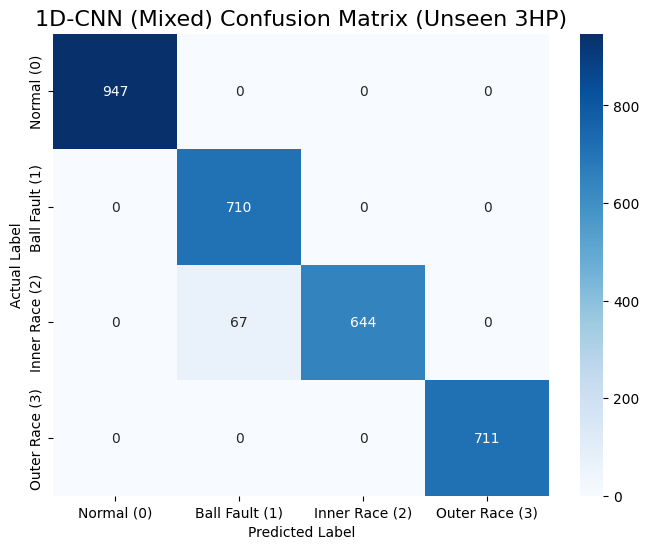

In [13]:
# --- 5.2. 1D-CNN Hyperparameter Tuning ---

def objective_cnn_mixed(trial):
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    
    model = CNN_Benchmark(in_channels=2, num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    best_val_acc_trial = 0.0
    for epoch in range(1, 20): # 20 epochs per trial
        # Use the MIXED RAW loaders
        train(model, train_loader_raw, optimizer, criterion, device) 
        _, val_acc = evaluate(model, val_loader_raw, criterion, device) 
        
        if val_acc > best_val_acc_trial:
            best_val_acc_trial = val_acc
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return best_val_acc_trial

# --- Run Optuna Study ---
study_cnn_mixed = optuna.create_study(direction='maximize')
print(f"Starting Optuna study for 1D-CNN Benchmark on Mixed Data...")
study_cnn_mixed.optimize(objective_cnn_mixed, n_trials=25)
best_params_cnn_mixed = study_cnn_mixed.best_trial.params

print("\nOptuna study for mixed 1D-CNN finished.")
print(f"Best Params: {best_params_cnn_mixed}")

# --- 5.3. 1D-CNN Final Training and Evaluation ---

print("\n--- Retraining 1D-CNN (Mixed) model with its best parameters ---")
final_model_cnn_mixed = CNN_Benchmark(
    in_channels=2,
    num_classes=num_classes,
    dropout_rate=best_params_cnn_mixed['dropout_rate']
).to(device)
final_optimizer_cnn_mixed = torch.optim.Adam(
    final_model_cnn_mixed.parameters(),
    lr=best_params_cnn_mixed['lr'],
    weight_decay=1e-5
)

print(f"Using Dropout Rate: {best_params_cnn_mixed['dropout_rate']:.4f}, LR: {best_params_cnn_mixed['lr']:.6f}")
print("Starting final training run for 1D-CNN (Mixed)...")

for epoch in range(1, 21): # Train for 20 epochs
    train_loss = train(final_model_cnn_mixed, train_loader_raw, final_optimizer_cnn_mixed, criterion, device) 
    val_loss, val_acc = evaluate(final_model_cnn_mixed, val_loader_raw, criterion, device) 
    print(f"Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# --- 5.4. Final Evaluation of 1D-CNN (Mixed) ---

# 1. Evaluate on Same-Distribution Test Set
test_loss_cnn_mixed_samedist, test_acc_cnn_mixed_samedist = evaluate(
    final_model_cnn_mixed, 
    test_loader_raw_samedist, 
    criterion, 
    device
) 
print("\n--- Final Evaluation of 1D-CNN (Mixed) on Same-Distribution Test Set (0,1,2 HP) ---")
print(f"Test Accuracy (1D-CNN, Same-Dist): {test_acc_cnn_mixed_samedist:.4f}")
print("================================================================================")

# 2. Evaluate on Unseen-HP Test Set
test_loss_cnn_mixed_unseen, test_acc_cnn_mixed_unseen = evaluate(
    final_model_cnn_mixed, 
    test_loader_raw_unseen, 
    criterion, 
    device
) 
print("\n--- Final Evaluation of 1D-CNN (Mixed) on Unseen 3HP Test Set ---")
print(f"Test Accuracy (1D-CNN, Unseen): {test_acc_cnn_mixed_unseen:.4f}")
print("================================================================")

# --- 5.5. 1D-CNN Unseen Test Set Analysis ---
print("\n--- 1D-CNN (Mixed) Classification Report (Unseen 3HP Test Set) ---")
y_true_cnn, y_pred_cnn = get_all_preds(final_model_cnn_mixed, test_loader_raw_unseen, device)
print(classification_report(y_true_cnn, y_pred_cnn, target_names=CLASS_NAMES, labels=[0, 1, 2, 3], digits=4, zero_division=0))

# Store results for final summary
report_cnn = get_classification_report_df(y_true_cnn, y_pred_cnn, "1D-CNN (Mixed)")

plot_confusion_matrix(y_true_cnn, y_pred_cnn, "1D-CNN (Mixed) Confusion Matrix (Unseen 3HP)")

## 6. Model 2: ST-GNN v1 (LSTM -> GAT)

This is our first Spatio-Temporal Graph Neural Network model. It uses the same **mixed-load raw signal data** as the 1D-CNN benchmark.

This architecture, which we call **`ST-GNN v1`**, processes the data in the following order:
1.  **Temporal (LSTM):** An LSTM layer processes the 1024-point time-series for each node (sensor) independently.
2.  **Spatial (GAT):** The output hidden states from the LSTMs are then passed to a Graph Attention (GAT) layer, which fuses the information from the two nodes.

### 6.1. ST-GNN v1 Model Definition

In [15]:
# --- 6.1. ST-GNN v1 Model Definition (LSTM -> GAT) ---

class SpatioTemporalGNN(torch.nn.Module):
    def __init__(self, num_nodes, signal_length, rnn_hidden_size, gnn_hidden_size, num_classes, dropout_rate, heads=2):
        super(SpatioTemporalGNN, self).__init__()
        self.num_nodes = num_nodes
        self.signal_length = signal_length
        self.rnn_hidden_size = rnn_hidden_size
        self.gnn_heads = heads
        self.gnn_out_features = gnn_hidden_size * self.gnn_heads
        
        self.input_bn = BatchNorm1d(num_nodes)
        
        # 1. Temporal Module (LSTM)
        # Processes each node's raw signal (1024 points) independently
        self.temporal_module = LSTM(input_size=signal_length, hidden_size=rnn_hidden_size, num_layers=1, batch_first=True)
        self.temporal_dropout = Dropout(dropout_rate)
        
        # 2. Spatial Module (GAT)
        # Fuses the features from the LSTM outputs
        self.spatial_module = GATConv(in_channels=rnn_hidden_size, out_channels=gnn_hidden_size, heads=self.gnn_heads, concat=True)
        self.spatial_bn = BatchNorm1d(self.gnn_out_features)
        self.spatial_dropout = Dropout(dropout_rate)
        
        # 3. Classifier
        self.classifier = Linear(self.gnn_out_features, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        B = data.num_graphs # Batch size
        
        # x shape is [B*N, F] where N=2, F=1024
        # Reshape to [B, N, F] for BatchNorm
        x_reshaped = x.view(B, self.num_nodes, self.signal_length)
        x_norm = self.input_bn(x_reshaped)
        
        # Flatten back to [B*N, F] for independent LSTM processing
        x_norm = x_norm.view(-1, self.signal_length)
        
        # 1. Temporal Processing
        # Input to LSTM needs to be [B*N, L, H_in] where L=1 (sequence length), H_in=1024
        x_temporal = x_norm.unsqueeze(1) 
        _, (h_n, _) = self.temporal_module(x_temporal)
        
        # h_n shape is [1, B*N, rnn_hidden_size]. Squeeze to [B*N, rnn_hidden_size]
        x_spatial = h_n.squeeze(0)
        x_spatial = self.temporal_dropout(x_spatial)
        
        # 2. Spatial Processing
        # GATConv takes node features [B*N, rnn_hidden_size] and edge_index
        x_spatial = self.spatial_module(x_spatial, edge_index)
        x_spatial = self.spatial_bn(x_spatial)
        x_spatial = F.relu(x_spatial)
        x_spatial = self.spatial_dropout(x_spatial)
        
        # 3. Readout and Classify
        # Pool node features to get a graph-level embedding
        x_graph = global_mean_pool(x_spatial, batch) 
        out = self.classifier(x_graph)
        return F.log_softmax(out, dim=1)

print("ST-GNN v1 (LSTM -> GAT) model class defined.")

# --- 6.2. Print Model Architecture ---
print("\n--- ST-GNN v1 Architecture (LSTM -> GAT) ---")
print("[Schematic omitted due to torchinfo tracing error]")

ST-GNN v1 (LSTM -> GAT) model class defined.

--- ST-GNN v1 Architecture (LSTM -> GAT) ---
[Schematic omitted due to torchinfo tracing error]


[I 2025-11-08 11:12:53,392] A new study created in memory with name: no-name-448f3403-460a-4e91-82fc-82c8dfe8d6e1


Starting Optuna study for ST-GNN v1 for 25 trials...


[I 2025-11-08 11:13:08,397] Trial 0 finished with value: 0.8276904474002419 and parameters: {'dropout_rate': 0.3350210385086879, 'lr': 0.008065245691863373, 'rnn_hidden_size': 32, 'gnn_hidden_size': 64}. Best is trial 0 with value: 0.8276904474002419.
[I 2025-11-08 11:13:23,157] Trial 1 finished with value: 0.8295042321644498 and parameters: {'dropout_rate': 0.1710354781994355, 'lr': 0.0013415896520375334, 'rnn_hidden_size': 64, 'gnn_hidden_size': 256}. Best is trial 1 with value: 0.8295042321644498.
[I 2025-11-08 11:13:37,896] Trial 2 finished with value: 0.8258766626360339 and parameters: {'dropout_rate': 0.1442414166580842, 'lr': 0.0007839113684256426, 'rnn_hidden_size': 64, 'gnn_hidden_size': 256}. Best is trial 1 with value: 0.8295042321644498.
[I 2025-11-08 11:13:52,523] Trial 3 finished with value: 0.8428053204353083 and parameters: {'dropout_rate': 0.2579197321283212, 'lr': 0.006873406267058402, 'rnn_hidden_size': 32, 'gnn_hidden_size': 256}. Best is trial 3 with value: 0.84280


Optuna study for ST-GNN v1 finished.
Best Params: {'dropout_rate': 0.3944912917868534, 'lr': 0.008842853040168167, 'rnn_hidden_size': 64, 'gnn_hidden_size': 64}

--- Retraining ST-GNN v1 on Mixed-Load (0,1,2 HP) Data ---
Using Params: {'dropout_rate': 0.3944912917868534, 'lr': 0.008842853040168167, 'rnn_hidden_size': 64, 'gnn_hidden_size': 64}
Starting final training run...
Epoch: 01, Time: 0.73s, Train Loss: 0.7112, Val Loss: 0.4584, Val Acc: 0.7950
Epoch: 02, Time: 0.77s, Train Loss: 0.2806, Val Loss: 0.4757, Val Acc: 0.8102
Epoch: 03, Time: 0.73s, Train Loss: 0.1995, Val Loss: 0.5196, Val Acc: 0.8005
Epoch: 04, Time: 0.72s, Train Loss: 0.1391, Val Loss: 0.5043, Val Acc: 0.8077
Epoch: 05, Time: 0.74s, Train Loss: 0.1146, Val Loss: 0.4709, Val Acc: 0.8162
Epoch: 06, Time: 0.74s, Train Loss: 0.0971, Val Loss: 0.6167, Val Acc: 0.7817
Epoch: 07, Time: 0.73s, Train Loss: 0.0915, Val Loss: 0.4814, Val Acc: 0.8241
Epoch: 08, Time: 0.74s, Train Loss: 0.0985, Val Loss: 0.6157, Val Acc: 0.807

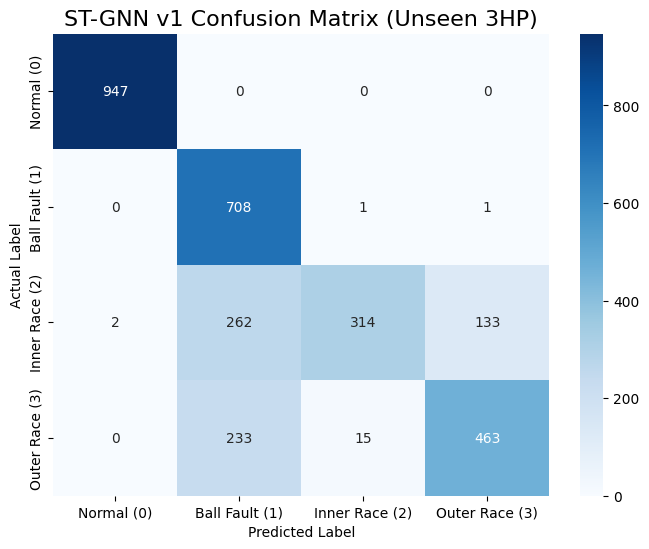

In [16]:
# --- 6.3. ST-GNN v1 Hyperparameter Tuning ---

def objective_stgnn_v1(trial):
    # Suggest hyperparameters
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    rnn_hidden_size = trial.suggest_categorical('rnn_hidden_size', [32, 64, 128])
    gnn_hidden_size = trial.suggest_categorical('gnn_hidden_size', [64, 128, 256])
    
    # Initialize model and optimizer for this trial
    model_opt = SpatioTemporalGNN(
        num_nodes=2, signal_length=WINDOW_SIZE,
        rnn_hidden_size=rnn_hidden_size, gnn_hidden_size=gnn_hidden_size,
        num_classes=num_classes, dropout_rate=dropout_rate, heads=2
    ).to(device)
    
    optimizer_opt = torch.optim.Adam(model_opt.parameters(), lr=lr, weight_decay=1e-5)

    num_epochs_optuna = 20
    best_val_acc_trial = 0.0

    # Training loop
    for epoch in range(1, num_epochs_optuna + 1):
        # Use the MIXED RAW loaders
        train(model_opt, train_loader_raw, optimizer_opt, criterion, device)
        val_loss, val_acc = evaluate(model_opt, val_loader_raw, criterion, device)
        
        if val_acc > best_val_acc_trial:
            best_val_acc_trial = val_acc
        
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_acc_trial

# --- Run the Optuna Study ---
n_trials = 25 
study_stgnn_v1 = optuna.create_study(direction='maximize')
print(f"Starting Optuna study for ST-GNN v1 for {n_trials} trials...")

study_stgnn_v1.optimize(objective_stgnn_v1, n_trials=n_trials)

print("\nOptuna study for ST-GNN v1 finished.")
best_params_stgnn_v1 = study_stgnn_v1.best_trial.params
print(f"Best Params: {best_params_stgnn_v1}")

# --- 6.4. ST-GNN v1 Final Training and Evaluation ---
print("\n--- Retraining ST-GNN v1 on Mixed-Load (0,1,2 HP) Data ---")

final_model_stgnn_v1 = SpatioTemporalGNN(
    num_nodes=2, signal_length=WINDOW_SIZE,
    rnn_hidden_size=best_params_stgnn_v1['rnn_hidden_size'], 
    gnn_hidden_size=best_params_stgnn_v1['gnn_hidden_size'],
    num_classes=num_classes,
    dropout_rate=best_params_stgnn_v1['dropout_rate'],
    heads=2
).to(device)

final_optimizer_stgnn_v1 = torch.optim.Adam(
    final_model_stgnn_v1.parameters(),
    lr=best_params_stgnn_v1['lr'],
    weight_decay=1e-5
)

num_epochs_final = 20
print(f"Using Params: {best_params_stgnn_v1}")
print("Starting final training run...")

best_val_acc_mixed = 0.0
for epoch in range(1, num_epochs_final + 1):
    start_time = time.time()
    
    train_loss = train(final_model_stgnn_v1, train_loader_raw, final_optimizer_stgnn_v1, criterion, device)
    val_loss, val_acc = evaluate(final_model_stgnn_v1, val_loader_raw, criterion, device)
    end_time = time.time()
    
    if val_acc > best_val_acc_mixed:
        best_val_acc_mixed = val_acc

    print(f"Epoch: {epoch:02d}, "
          f"Time: {end_time - start_time:.2f}s, "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}")

print(f"\nFinal mixed retraining complete. Best Validation Acc: {best_val_acc_mixed:.4f}")

# --- 6.5. Final Evaluation of ST-GNN v1 ---

# 1. Evaluate on Same-Distribution Test Set
test_loss_stgnn_v1_samedist, test_acc_stgnn_v1_samedist = evaluate(
    final_model_stgnn_v1, 
    test_loader_raw_samedist, 
    criterion, 
    device
) 
print("\n--- Final Evaluation of ST-GNN v1 on Same-Distribution Test Set (0,1,2 HP) ---")
print(f"Test Accuracy (ST-GNN v1, Same-Dist): {test_acc_stgnn_v1_samedist:.4f}")
print("============================================================================")

# 2. Evaluate on Unseen-HP Test Set
test_loss_stgnn_v1_unseen, test_acc_stgnn_v1_unseen = evaluate(
    final_model_stgnn_v1, 
    test_loader_raw_unseen, 
    criterion, 
    device
) 
print("\n--- Final Evaluation of ST-GNN v1 on Unseen 3HP Test Set ---")
print(f"Test Accuracy (ST-GNN v1, Unseen): {test_acc_stgnn_v1_unseen:.4f}")
print("============================================================")

# --- 6.6. ST-GNN v1 Unseen Test Set Analysis ---
print("\n--- ST-GNN v1 Classification Report (Unseen 3HP Test Set) ---")
y_true_v1, y_pred_v1 = get_all_preds(final_model_stgnn_v1, test_loader_raw_unseen, device)
print(classification_report(y_true_v1, y_pred_v1, target_names=CLASS_NAMES, labels=[0, 1, 2, 3], digits=4, zero_division=0))

# Store results for final summary
report_v1 = get_classification_report_df(y_true_v1, y_pred_v1, "ST-GNN v1 (Mixed)")

plot_confusion_matrix(y_true_v1, y_pred_v1, "ST-GNN v1 Confusion Matrix (Unseen 3HP)")

## 7. Model 3: ST-GNN v2 (LSTM -> GAT + Features)

Our first GNN model (v1) performed worse than the 1D-CNN on raw signals, struggling to distinguish faults (especially Inner Race) under varying loads.

[cite_start]As outlined in the research paper[cite: 151, 155], feature engineering is a crucial step. Our next model, **`ST-GNN v2`**, will test this. [cite_start]It uses the same **`LSTM -> GAT`** architecture as v1, but instead of raw signals, it will be fed the **11 handcrafted features** (6 time-domain, 5 frequency-domain) we extracted in Section 4[cite: 142].

This model will be trained on the `train_loader_feat` and `val_loader_feat` DataLoaders.

### 7.1. ST-GNN v2 Model Definition

In [17]:
# --- 7.1. ST-GNN v2 Model Definition (LSTM -> GAT + Features) ---

class ST_GNN_v2_Feat(torch.nn.Module):
    # This is our original (v1) architecture: LSTM -> GAT
    # But it takes N_FEATURES as input instead of the raw signal length
    
    def __init__(self, num_nodes, feature_length, rnn_hidden_size, gnn_hidden_size, num_classes, dropout_rate, heads=2):
        super(ST_GNN_v2_Feat, self).__init__()
        self.num_nodes = num_nodes
        self.feature_length = feature_length # e.g., 11
        self.rnn_hidden_size = rnn_hidden_size
        self.gnn_heads = heads
        self.gnn_out_features = gnn_hidden_size * self.gnn_heads
        
        self.input_bn = BatchNorm1d(num_nodes)
        
        # 1. Temporal Module (LSTM)
        # Input size is now feature_length, not WINDOW_SIZE
        self.temporal_module = LSTM(
            input_size=self.feature_length, 
            hidden_size=rnn_hidden_size, 
            num_layers=1, 
            batch_first=True
        )
        self.temporal_dropout = Dropout(dropout_rate)
        
        # 2. Spatial Module (GAT)
        self.spatial_module = GATConv(in_channels=rnn_hidden_size, out_channels=gnn_hidden_size, heads=self.gnn_heads, concat=True)
        self.spatial_bn = BatchNorm1d(self.gnn_out_features)
        self.spatial_dropout = Dropout(dropout_rate)
        
        # 3. Classifier
        self.classifier = Linear(self.gnn_out_features, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        B = data.num_graphs # Batch size
        
        # x shape is now [B*N, N_FEATURES]
        # Reshape to [B, N, N_FEATURES] for BatchNorm
        x_reshaped = x.view(B, self.num_nodes, self.feature_length)
        x_norm = self.input_bn(x_reshaped)
        
        # Flatten back to [B*N, N_FEATURES] for independent LSTM processing
        x_norm_flat = x_norm.view(-1, self.feature_length) 
        
        # 1. Temporal Processing
        # Input to LSTM needs to be [B*N, L, H_in] where L=1 (sequence length), H_in=N_FEATURES
        x_temporal = x_norm_flat.unsqueeze(1) 
        
        _, (h_n, _) = self.temporal_module(x_temporal)
        
        # h_n shape is [1, B*N, rnn_hidden_size]. Squeeze to [B*N, rnn_hidden_size]
        x_spatial = h_n.squeeze(0)
        x_spatial = self.temporal_dropout(x_spatial)
        
        # 2. Spatial Processing
        x_spatial = self.spatial_module(x_spatial, edge_index)
        x_spatial = self.spatial_bn(x_spatial)
        x_spatial = F.relu(x_spatial)
        x_spatial = self.spatial_dropout(x_spatial)
        
        # 3. Readout and Classify
        x_graph = global_mean_pool(x_spatial, batch) 
        out = self.classifier(x_graph)
        return F.log_softmax(out, dim=1)

print("ST-GNN v2 (LSTM -> GAT + Features) model class defined.")

ST-GNN v2 (LSTM -> GAT + Features) model class defined.


[I 2025-11-08 11:16:48,783] A new study created in memory with name: no-name-03412fdc-eb38-4900-8c53-66dcd78ecb8f


Starting Optuna study for ST-GNN v2 for 25 trials...


[I 2025-11-08 11:17:02,557] Trial 0 finished with value: 0.9165659008464329 and parameters: {'dropout_rate': 0.4343363697284278, 'lr': 0.0009110684760820382, 'rnn_hidden_size': 16, 'gnn_hidden_size': 32}. Best is trial 0 with value: 0.9165659008464329.
[I 2025-11-08 11:17:16,225] Trial 1 finished with value: 0.9812575574365175 and parameters: {'dropout_rate': 0.16050596243426268, 'lr': 0.0028503659333347893, 'rnn_hidden_size': 16, 'gnn_hidden_size': 32}. Best is trial 1 with value: 0.9812575574365175.
[I 2025-11-08 11:17:30,083] Trial 2 finished with value: 0.9818621523579202 and parameters: {'dropout_rate': 0.30644119020984306, 'lr': 0.0014770027290530272, 'rnn_hidden_size': 16, 'gnn_hidden_size': 64}. Best is trial 2 with value: 0.9818621523579202.
[I 2025-11-08 11:17:43,842] Trial 3 finished with value: 0.9824667472793228 and parameters: {'dropout_rate': 0.36167929836435986, 'lr': 0.0020441302441933378, 'rnn_hidden_size': 32, 'gnn_hidden_size': 128}. Best is trial 3 with value: 0.98


Optuna study for ST-GNN v2 finished.
Best Params: {'dropout_rate': 0.11465025745191647, 'lr': 0.0027392111420717295, 'rnn_hidden_size': 64, 'gnn_hidden_size': 128}

--- Retraining ST_GNN v2 with best parameters ---
Using Params: {'dropout_rate': 0.11465025745191647, 'lr': 0.0027392111420717295, 'rnn_hidden_size': 64, 'gnn_hidden_size': 128}
Starting final training run for ST_GNN v2...
Epoch: 01, Time: 0.69s, Train Loss: 0.5201, Val Loss: 0.5841, Val Acc: 0.7636
Epoch: 02, Time: 0.70s, Train Loss: 0.2792, Val Loss: 0.3733, Val Acc: 0.8356
Epoch: 03, Time: 0.69s, Train Loss: 0.1920, Val Loss: 0.4939, Val Acc: 0.8392
Epoch: 04, Time: 0.68s, Train Loss: 0.1639, Val Loss: 0.2784, Val Acc: 0.8779
Epoch: 05, Time: 0.69s, Train Loss: 0.1496, Val Loss: 0.3024, Val Acc: 0.8761
Epoch: 06, Time: 0.70s, Train Loss: 0.1170, Val Loss: 0.3225, Val Acc: 0.8767
Epoch: 07, Time: 0.71s, Train Loss: 0.0945, Val Loss: 0.2606, Val Acc: 0.8966
Epoch: 08, Time: 0.71s, Train Loss: 0.0876, Val Loss: 0.1618, Val

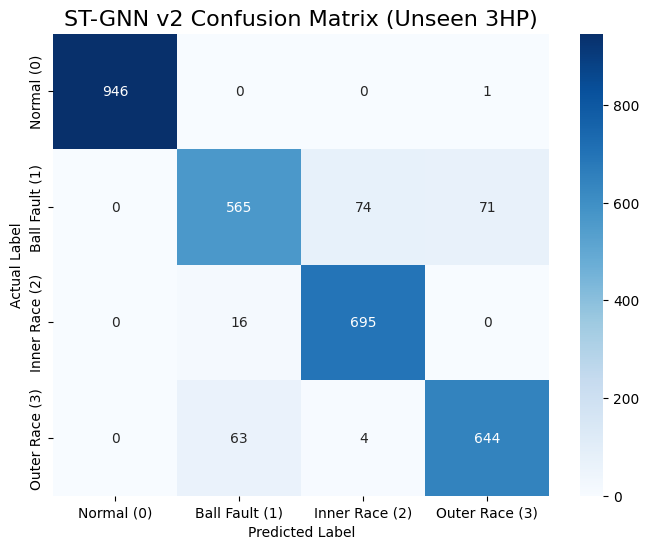

In [18]:
# --- 7.3. ST-GNN v2 Hyperparameter Tuning ---

def objective_stgnn_v2(trial):
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    rnn_hidden_size = trial.suggest_categorical('rnn_hidden_size', [16, 32, 64])
    gnn_hidden_size = trial.suggest_categorical('gnn_hidden_size', [32, 64, 128])
    
    model_opt = ST_GNN_v2_Feat(
        num_nodes=2, feature_length=N_FEATURES,
        rnn_hidden_size=rnn_hidden_size, 
        gnn_hidden_size=gnn_hidden_size,
        num_classes=num_classes, 
        dropout_rate=dropout_rate, 
        heads=2
    ).to(device)
    
    optimizer_opt = torch.optim.Adam(model_opt.parameters(), lr=lr, weight_decay=1e-5)

    num_epochs_optuna = 20 # 20 epochs
    best_val_acc_trial = 0.0

    for epoch in range(1, num_epochs_optuna + 1):
        # Train on the new FEATURE loader
        train(model_opt, train_loader_feat, optimizer_opt, criterion, device)
        # Validate on the new FEATURE loader
        val_loss, val_acc = evaluate(model_opt, val_loader_feat, criterion, device)
        
        if val_acc > best_val_acc_trial:
            best_val_acc_trial = val_acc
        
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_acc_trial

# --- Run the new Optuna Study ---
n_trials_v2 = 25 
study_stgnn_v2 = optuna.create_study(direction='maximize')
print(f"Starting Optuna study for ST-GNN v2 for {n_trials_v2} trials...")

study_stgnn_v2.optimize(objective_stgnn_v2, n_trials=n_trials_v2)

print("\nOptuna study for ST-GNN v2 finished.")
best_params_stgnn_v2 = study_stgnn_v2.best_trial.params
print(f"Best Params: {best_params_stgnn_v2}")

# --- 7.4. ST-GNN v2 Final Training and Evaluation ---
print("\n--- Retraining ST_GNN v2 with best parameters ---")

final_model_stgnn_v2 = ST_GNN_v2_Feat(
    num_nodes=2, feature_length=N_FEATURES,
    rnn_hidden_size=best_params_stgnn_v2['rnn_hidden_size'],
    gnn_hidden_size=best_params_stgnn_v2['gnn_hidden_size'],
    num_classes=num_classes,
    dropout_rate=best_params_stgnn_v2['dropout_rate'],
    heads=2
).to(device)

final_optimizer_stgnn_v2 = torch.optim.Adam(
    final_model_stgnn_v2.parameters(),
    lr=best_params_stgnn_v2['lr'],
    weight_decay=1e-5
)

num_epochs_final = 20 # Train for 20 epochs
print(f"Using Params: {best_params_stgnn_v2}")
print("Starting final training run for ST_GNN v2...")

best_val_acc_v2 = 0.0
for epoch in range(1, num_epochs_final + 1):
    start_time = time.time()
    
    train_loss = train(final_model_stgnn_v2, train_loader_feat, final_optimizer_stgnn_v2, criterion, device)
    val_loss, val_acc = evaluate(final_model_stgnn_v2, val_loader_feat, criterion, device)
    end_time = time.time()
    
    if val_acc > best_val_acc_v2:
        best_val_acc_v2 = val_acc

    print(f"Epoch: {epoch:02d}, "
          f"Time: {end_time - start_time:.2f}s, "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}")

print(f"\nFinal retraining complete. Best Validation Acc: {best_val_acc_v2:.4f}")

# --- 7.5. Final Evaluation of ST-GNN v2 ---

# 1. Evaluate on Same-Distribution Test Set
test_loss_stgnn_v2_samedist, test_acc_stgnn_v2_samedist = evaluate(
    final_model_stgnn_v2, 
    test_loader_feat_samedist, 
    criterion, 
    device
) 
print("\n--- Final Evaluation of ST-GNN v2 on Same-Distribution Test Set (0,1,2 HP) ---")
print(f"Test Accuracy (ST-GNN v2, Same-Dist): {test_acc_stgnn_v2_samedist:.4f}")
print("============================================================================")

# 2. Evaluate on Unseen-HP Test Set
test_loss_stgnn_v2_unseen, test_acc_stgnn_v2_unseen = evaluate(
    final_model_stgnn_v2, 
    test_loader_feat_unseen, 
    criterion, 
    device
) 
print("\n--- Final Evaluation of ST-GNN v2 on Unseen 3HP Test Set ---")
print(f"Test Accuracy (ST-GNN v2, Unseen): {test_acc_stgnn_v2_unseen:.4f}")
print("============================================================")

# --- 7.6. ST-GNN v2 Unseen Test Set Analysis ---
print("\n--- ST-GNN v2 Classification Report (Unseen 3HP Test Set) ---")
y_true_v2, y_pred_v2 = get_all_preds(final_model_stgnn_v2, test_loader_feat_unseen, device)
print(classification_report(y_true_v2, y_pred_v2, target_names=CLASS_NAMES, labels=[0, 1, 2, 3], digits=4, zero_division=0))

# Store results for final summary
report_v2 = get_classification_report_df(y_true_v2, y_pred_v2, "ST-GNN v2 (Features)")

plot_confusion_matrix(y_true_v2, y_pred_v2, "ST-GNN v2 Confusion Matrix (Unseen 3HP)")

## 8. Model 4: ST-GNN v3 (LSTM -> GAT + Features + Weights)

We have now seen that:
1.  **Mixed-load training** is essential.
2.  **Handcrafted features (ST-GNN v2)** dramatically improve performance over raw signals (ST-GNN v1).

Now, we will test another hypothesis from the original notebook: **Do physically meaningful edge weights improve the model?**

This model, **`ST-GNN v3`**, combines all successful components so far:
* **Architecture:** `LSTM -> GAT` (from v1/v2).
* **Input:** `11 Handcrafted Features` (from v2).
* **Graph:** `Weighted Edges` based on the cross-correlation of the raw sensor signals.

This model will be trained on the `train_loader_feat_w` and `val_loader_feat_w` DataLoaders.

### 8.1. ST-GNN v3 Model Definition

In [19]:
# --- 8.1. ST-GNN v3 Model Definition (LSTM -> GAT + Features + Weights) ---

class ST_GNN_v3_w(torch.nn.Module):
    # This is our ST-GNN v2 model, modified to accept edge_weight
    
    def __init__(self, num_nodes, feature_length, rnn_hidden_size, gnn_hidden_size, num_classes, dropout_rate, heads=2):
        super(ST_GNN_v3_w, self).__init__()
        self.num_nodes = num_nodes
        self.feature_length = feature_length
        self.rnn_hidden_size = rnn_hidden_size
        self.gnn_heads = heads
        self.gnn_out_features = gnn_hidden_size * self.gnn_heads
        
        self.input_bn = BatchNorm1d(num_nodes)
        self.temporal_module = LSTM(
            input_size=self.feature_length, 
            hidden_size=rnn_hidden_size, 
            num_layers=1, 
            batch_first=True
        )
        self.temporal_dropout = Dropout(dropout_rate)
        
        # GATConv now receives edge_attr in the forward pass
        self.spatial_module = GATConv(in_channels=rnn_hidden_size, out_channels=gnn_hidden_size, heads=self.gnn_heads, concat=True)
        self.spatial_bn = BatchNorm1d(self.gnn_out_features)
        self.spatial_dropout = Dropout(dropout_rate)
        self.classifier = Linear(self.gnn_out_features, num_classes)

    def forward(self, data):
        # Add edge_weight to the input
        x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight
        B = data.num_graphs
        
        x_reshaped = x.view(B, self.num_nodes, self.feature_length)
        x_norm = self.input_bn(x_reshaped)
        
        x_norm_flat = x_norm.view(-1, self.feature_length)
        x_temporal = x_norm_flat.unsqueeze(1)
        
        _, (h_n, _) = self.temporal_module(x_temporal)
        
        x_spatial = h_n.squeeze(0)
        x_spatial = self.temporal_dropout(x_spatial)
        
        # Pass edge_weight to the GAT layer
        x_spatial = self.spatial_module(x_spatial, edge_index, edge_attr=edge_weight)
        
        x_spatial = self.spatial_bn(x_spatial)
        x_spatial = F.relu(x_spatial)
        x_spatial = self.spatial_dropout(x_spatial)
        
        x_graph = global_mean_pool(x_spatial, batch)
        out = self.classifier(x_graph)
        return F.log_softmax(out, dim=1)

print("ST-GNN v3 (LSTM -> GAT + Features + Weights) model class defined.")

ST-GNN v3 (LSTM -> GAT + Features + Weights) model class defined.


[I 2025-11-08 11:20:50,354] A new study created in memory with name: no-name-0fd48822-83df-4b27-a7fa-ee3b82a9e232


Starting Optuna study for ST-GNN v3 for 25 trials...


[I 2025-11-08 11:21:05,110] Trial 0 finished with value: 0.9854897218863361 and parameters: {'dropout_rate': 0.2688342471995667, 'lr': 0.0035732527081141605, 'rnn_hidden_size': 64, 'gnn_hidden_size': 32}. Best is trial 0 with value: 0.9854897218863361.
[I 2025-11-08 11:21:19,872] Trial 1 finished with value: 0.9764207980652962 and parameters: {'dropout_rate': 0.498182251990993, 'lr': 0.0032938654691748647, 'rnn_hidden_size': 64, 'gnn_hidden_size': 64}. Best is trial 0 with value: 0.9854897218863361.
[I 2025-11-08 11:21:34,699] Trial 2 finished with value: 0.8482466747279322 and parameters: {'dropout_rate': 0.48542434348860886, 'lr': 0.00029047841756251966, 'rnn_hidden_size': 64, 'gnn_hidden_size': 64}. Best is trial 0 with value: 0.9854897218863361.
[I 2025-11-08 11:21:49,434] Trial 3 finished with value: 0.9830713422007256 and parameters: {'dropout_rate': 0.19712357367220507, 'lr': 0.0012720073756726706, 'rnn_hidden_size': 16, 'gnn_hidden_size': 128}. Best is trial 0 with value: 0.985


Optuna study for v3 finished.
Best Params: {'dropout_rate': 0.2326832759144639, 'lr': 0.004341314581531951, 'rnn_hidden_size': 32, 'gnn_hidden_size': 128}

--- Retraining ST-GNN v3 with best parameters ---
Using Params: {'dropout_rate': 0.2326832759144639, 'lr': 0.004341314581531951, 'rnn_hidden_size': 32, 'gnn_hidden_size': 128}
Starting final training run for ST-GNN v3...
Epoch: 01, Time: 0.73s, Train Loss: 0.4874, Val Loss: 0.4147, Val Acc: 0.7920
Epoch: 02, Time: 0.74s, Train Loss: 0.2242, Val Loss: 0.1925, Val Acc: 0.9305
Epoch: 03, Time: 0.76s, Train Loss: 0.1547, Val Loss: 0.1352, Val Acc: 0.9686
Epoch: 04, Time: 0.74s, Train Loss: 0.1301, Val Loss: 0.1934, Val Acc: 0.9571
Epoch: 05, Time: 0.76s, Train Loss: 0.1042, Val Loss: 0.1353, Val Acc: 0.9740
Epoch: 06, Time: 0.76s, Train Loss: 0.0914, Val Loss: 0.2067, Val Acc: 0.9528
Epoch: 07, Time: 0.73s, Train Loss: 0.1139, Val Loss: 0.0949, Val Acc: 0.9813
Epoch: 08, Time: 0.74s, Train Loss: 0.0850, Val Loss: 0.1247, Val Acc: 0.979

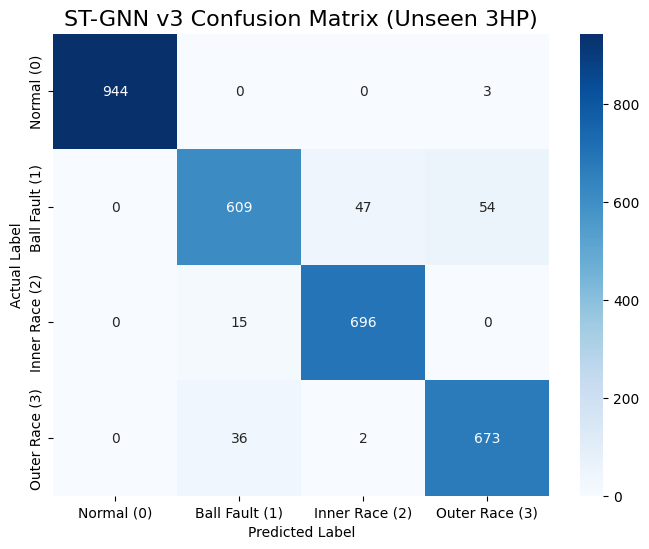

In [20]:
# --- 8.3. ST-GNN v3 Hyperparameter Tuning ---

def objective_stgnn_v3(trial):
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    rnn_hidden_size = trial.suggest_categorical('rnn_hidden_size', [16, 32, 64])
    gnn_hidden_size = trial.suggest_categorical('gnn_hidden_size', [32, 64, 128])
    
    model_opt = ST_GNN_v3_w(
        num_nodes=2, feature_length=N_FEATURES,
        rnn_hidden_size=rnn_hidden_size, 
        gnn_hidden_size=gnn_hidden_size,
        num_classes=num_classes, 
        dropout_rate=dropout_rate, 
        heads=2
    ).to(device)
    
    optimizer_opt = torch.optim.Adam(model_opt.parameters(), lr=lr, weight_decay=1e-5)
    num_epochs_optuna = 20

    best_val_acc_trial = 0.0
    for epoch in range(1, num_epochs_optuna + 1):
        # Train on the WEIGHTED FEATURE loader
        train(model_opt, train_loader_feat_w, optimizer_opt, criterion, device)
        # Validate on the WEIGHTED FEATURE loader
        val_loss, val_acc = evaluate(model_opt, val_loader_feat_w, criterion, device)
        
        if val_acc > best_val_acc_trial:
            best_val_acc_trial = val_acc
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return best_val_acc_trial

# --- Run the new Optuna Study ---
n_trials_v3 = 25
study_stgnn_v3 = optuna.create_study(direction='maximize')
print(f"Starting Optuna study for ST-GNN v3 for {n_trials_v3} trials...")
study_stgnn_v3.optimize(objective_stgnn_v3, n_trials=n_trials_v3)

print("\nOptuna study for v3 finished.")
best_params_stgnn_v3 = study_stgnn_v3.best_trial.params
print(f"Best Params: {best_params_stgnn_v3}")


# --- 8.4. ST-GNN v3 Final Training and Evaluation ---
print("\n--- Retraining ST-GNN v3 with best parameters ---")
final_model_stgnn_v3 = ST_GNN_v3_w(
    num_nodes=2, feature_length=N_FEATURES,
    rnn_hidden_size=best_params_stgnn_v3['rnn_hidden_size'],
    gnn_hidden_size=best_params_stgnn_v3['gnn_hidden_size'],
    num_classes=num_classes,
    dropout_rate=best_params_stgnn_v3['dropout_rate'],
    heads=2
).to(device)

final_optimizer_stgnn_v3 = torch.optim.Adam(final_model_stgnn_v3.parameters(), lr=best_params_stgnn_v3['lr'], weight_decay=1e-5)
num_epochs_final = 20

print(f"Using Params: {best_params_stgnn_v3}")
print("Starting final training run for ST-GNN v3...")

for epoch in range(1, num_epochs_final + 1):
    start_time = time.time()
    train_loss = train(final_model_stgnn_v3, train_loader_feat_w, final_optimizer_stgnn_v3, criterion, device)
    val_loss, val_acc = evaluate(final_model_stgnn_v3, val_loader_feat_w, criterion, device)
    end_time = time.time()
    print(f"Epoch: {epoch:02d}, "
          f"Time: {end_time - start_time:.2f}s, "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}")

# --- 8.5. Final Evaluation of ST-GNN v3 ---

# 1. Evaluate on Same-Distribution Test Set
test_loss_stgnn_v3_samedist, test_acc_stgnn_v3_samedist = evaluate(
    final_model_stgnn_v3, 
    test_loader_feat_samedist_w, 
    criterion, 
    device
) 
print("\n--- Final Evaluation of ST-GNN v3 on Same-Distribution Test Set (0,1,2 HP) ---")
print(f"Test Accuracy (ST-GNN v3, Same-Dist): {test_acc_stgnn_v3_samedist:.4f}")
print("============================================================================")

# 2. Evaluate on Unseen-HP Test Set
test_loss_stgnn_v3_unseen, test_acc_stgnn_v3_unseen = evaluate(
    final_model_stgnn_v3, 
    test_loader_feat_unseen_w, 
    criterion, 
    device
) 
print("\n--- Final Evaluation of ST-GNN v3 on Unseen 3HP Test Set ---")
print(f"Test Accuracy (ST-GNN v3, Unseen): {test_acc_stgnn_v3_unseen:.4f}")
print("============================================================")

# --- 8.6. ST-GNN v3 Unseen Test Set Analysis ---
print("\n--- ST-GNN v3 Classification Report (Unseen 3HP Test Set) ---")
y_true_v3, y_pred_v3 = get_all_preds(final_model_stgnn_v3, test_loader_feat_unseen_w, device)
print(classification_report(y_true_v3, y_pred_v3, target_names=CLASS_NAMES, labels=[0, 1, 2, 3], digits=4, zero_division=0))

# Store results for final summary
report_v3 = get_classification_report_df(y_true_v3, y_pred_v3, "ST-GNN v3 (Features + Weights)")

plot_confusion_matrix(y_true_v3, y_pred_v3, "ST-GNN v3 Confusion Matrix (Unseen 3HP)")

## 9. Final Experimental Summary

We have now trained and evaluated all four target models using the corrected mixed-load training strategy. This section compiles the final performance metrics for a direct comparison.

We will generate two summary tables:
1.  **High-Level Summary:** A table comparing the models based on their input, strategy, same-distribution accuracy, and unseen 3HP (robustness) accuracy.
2.  **Detailed Performance Summary:** A table breaking down the recall, precision, and f1-score for each fault class (Normal, Ball, Inner Race, Outer Race) on the unseen 3HP test set. This will clearly show which models succeeded or failed at identifying specific faults.

In [23]:
# --- 9.1. Final High-Level Summary Table ---

print("--- Final Experimental Summary Table ---")

try:
    # 1. Collect all the accuracy data
    data = {
        "Same-Distribution Accuracy": [
            f"{test_acc_cnn_mixed_samedist * 100:.2f}% (0,1,2HP Test Set)",
            f"{test_acc_stgnn_v1_samedist * 100:.2f}% (0,1,2HP Test Set)",
            f"{test_acc_stgnn_v2_samedist * 100:.2f}% (0,1,2HP Test Set)",
            f"{test_acc_stgnn_v3_samedist * 100:.2f}% (0,1,2HP Test Set)",
        ],
        "Unseen-HP Accuracy (Robustness)": [
            f"{test_acc_cnn_mixed_unseen * 100:.2f}% (3HP Test Set)",
            f"{test_acc_stgnn_v1_unseen * 100:.2f}% (3HP Test Set)",
            f"{test_acc_stgnn_v2_unseen * 100:.2f}% (3HP Test Set)",
            f"{test_acc_stgnn_v3_unseen * 100:.2f}% (3HP Test Set)",
        ],
        "Input Type": [
            "Raw Signal", 
            "Raw Signal", 
            "11 Features", 
            "11 Features + Weighted Edge"
        ],
        "Architecture": [
            "1D-CNN",
            "LSTM -> GAT",
            "LSTM -> GAT",
            "LSTM -> GAT",
        ]
    }

    # 2. Define the row index
    index_names = [
        "1D-CNN (Benchmark)",
        "ST-GNN v1 (Raw Signal)",
        "ST-GNN v2 (Features)",
        "ST-GNN v3 (Features + Weights)",
    ]

    # 3. Create and display the DataFrame
    summary_df_high_level = pd.DataFrame(data, index=index_names)

    # 4. Re-order columns
    summary_df_high_level = summary_df_high_level[[
        "Architecture",
        "Input Type",
        "Same-Distribution Accuracy",
        "Unseen-HP Accuracy (Robustness)"
    ]]

    # 5. Set pandas option to display the full text
    pd.set_option('display.max_colwidth', None)
    display(summary_df_high_level)

except NameError as e:
    print("\nERROR: Could not generate high-level summary table.")
    print(f"A required variable was not found (e.g., '{e.name}').")
    print("Please ensure you have run all model training cells (Sections 5, 6, 7, 8).")


# --- 9.2. Final Detailed Performance Summary Table (Horizontal) ---

print("\n--- Detailed Performance Summary (Unseen 3HP Test Set) ---")
try:
    # Concatenate all the report DataFrames stored from previous steps
    detailed_summary_df_vertical = pd.concat([
        report_cnn,
        report_v1,
        report_v2,
        report_v3
    ])
    
    # Set model and class as multi-index
    detailed_summary_df_vertical = detailed_summary_df_vertical.reset_index().rename(columns={'index': 'class'})
    detailed_summary_df_vertical = detailed_summary_df_vertical.set_index(['model', 'class'])
    
    # Drop the 'support' column as it's not a performance metric
    detailed_summary_df_no_support = detailed_summary_df_vertical.drop(columns='support')
    
    # --- THIS IS THE CHANGE: Unstack the 'model' level to make the table horizontal ---
    # This pivots the models to be the columns
    detailed_summary_df_horizontal = detailed_summary_df_no_support.unstack(level='model')
    
    # Reorder the column levels to have Model on top, then Metric
    detailed_summary_df_horizontal = detailed_summary_df_horizontal.swaplevel(0, 1, axis=1).sort_index(axis=1)

    # Display the new horizontal summary table
    print("Models and metrics are on the X-axis (columns), classes are on the Y-axis (rows).")
    with pd.option_context('display.precision', 4):
        display(detailed_summary_df_horizontal)

except NameError as e:
    print("\nERROR: Could not generate detailed summary table.")
    print(f"A required report variable was not found (e.g., '{e.name}').")
    print("Please ensure you have run all model training cells (Sections 5, 6, 7, 8).")

--- Final Experimental Summary Table ---


,Architecture,Input Type,Same-Distribution Accuracy,Unseen-HP Accuracy (Robustness)
1D-CNN (Benchmark),1D-CNN,Raw Signal,"99.92% (0,1,2HP Test Set)",97.82% (3HP Test Set)
ST-GNN v1 (Raw Signal),LSTM -> GAT,Raw Signal,"77.36% (0,1,2HP Test Set)",78.99% (3HP Test Set)
ST-GNN v2 (Features),LSTM -> GAT,11 Features,"90.12% (0,1,2HP Test Set)",92.56% (3HP Test Set)
ST-GNN v3 (Features + Weights),LSTM -> GAT,11 Features + Weighted Edge,"96.96% (0,1,2HP Test Set)",94.90% (3HP Test Set)



--- Detailed Performance Summary (Unseen 3HP Test Set) ---
Models and metrics are on the X-axis (columns), classes are on the Y-axis (rows).


model          1D-CNN (Mixed)                   ST-GNN v1 (Mixed)            \
                     f1-score precision  recall          f1-score precision   
class                                                                         
Ball Fault (1)         0.9549    0.9138  1.0000            0.7402    0.5885   
Inner Race (2)         0.9506    1.0000  0.9058            0.6033    0.9515   
Normal (0)             1.0000    1.0000  1.0000            0.9989    0.9979   
Outer Race (3)         1.0000    1.0000  1.0000            0.7080    0.7755   
weighted avg           0.9782    0.9801  0.9782            0.7807    0.8414   

model                  ST-GNN v2 (Features)                    \
                recall             f1-score precision  recall   
class                                                           
Ball Fault (1)  0.9972               0.8346    0.8773  0.7958   
Inner Race (2)  0.4416               0.9367    0.8991  0.9775   
Normal (0)      1.0000               0.9995    1.0000  0.9989   
Outer Race (3)  0.6512               0.9026    0.8994  0.9058   
weighted avg    0.7899               0.9246    0.9252  0.9256   

model          ST-GNN v3 (Features + Weights)                    
                                     f1-score precision  recall  
class                                                            
Ball Fault (1)                         0.8891    0.9227  0.8577  
Inner Race (2)                         0.9560    0.9342  0.9789  
Normal (0)                             0.9984    1.0000  0.9968  
Outer Race (3)                         0.9341    0.9219  0.9466  
weighted avg                           0.9486    0.9490  0.9490